# Lloyds Project
Note: 
1. All error plots and plots for checking that the best parameter from grid search is an optimal parameter is not included in the report.
2. Exact replicability of results in the report is quite difficult due to the randomness nature TensorFlow and Keras models. Despite setting seeds, different machines and environments may produce different results. (see: https://keras.io/examples/keras_recipes/reproducibility_recipes/)

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from keras.models import Model
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

from scipy.stats import norm, mode

import datetime as dt

# Define Prediction Class

In [2]:
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    '''
    class to contain predictions after each epoch of LSTM model training
    '''
    def __init__(self):
        self.epoch_predictions = []
        self.epoch_predictions_test = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_predictions.append(model.predict(trainX))
        self.epoch_predictions_test.append(model.predict(testX))

# Define Functions

## EDA

In [3]:
# plotting
def plot_anom(df, id, ax, legend_loc = 'upper left'):
    """
    plot spending data and anomalies for an id

    Args:
        df (pandas.DataFrame): dataframe of the dataset
        id (int): individual id of interest
        ax (matplotlib.axes): axis to plot
        legend_loc (string): legend location in plot

    Returns:
        None
    """
    # get individual data and plot spending
    indiv = df.loc[df['individual_id'] == id,:]
    indiv.plot(x = 'time', y='spend', ax=ax) 

    # store anomalies time
    anomaly_time = indiv.loc[indiv['at_risk_event'], ['time', 'spend']]
    anomaly_window = indiv.loc[indiv['at_risk_behaviour_window'].notna(), ['time', 'spend']]

    # scatter plot of anomalies
    ax.scatter(anomaly_time['time'], anomaly_time['spend'], color = 'red', label = 'At risk event', s=100)

    ax.scatter(anomaly_window['time'], anomaly_window['spend'], color = 'green', label = 'At risk behaviour window')
    ax.set_xlabel('Date')
    ax.set_ylabel('Spend')

    ax.legend(loc = legend_loc)

## Performance

In [4]:
def perf_nofit(y_pred, y_test, print_=True):

    """
    Evaluate model performance metrics

    Args:
        y_pred (numpy.ndarray): array of predicted flags
        y_test (numpy.ndarray): array of observed flags
        print_ (Boolean): set to True to print metric values

    Returns:
        dictionary: dictionary of performance metrics (FP, TN, TP, FN, recall, FNR, TNR, FPR, precision, and f1 score)
    """

    confmat = confusion_matrix(y_test, y_pred, labels=[1, 0])
    # Extracting the quantities from the confusion matrix
    FN = confmat[0,1]
    TP = confmat[0,0]
    TN = confmat[1,1]
    FP = confmat[1,0]
    
    #Calculation and displaying of Recall, FNR, TNR, FPR, and Precision, and F1 score
    Recall = (TP)/(TP+FN) 
    FNR = (FN)/(FN+TP)
    TNR = (TN)/(TN+FP) 
    FPR = (FP)/(FP+TN)
    Precision = (TP)/(FP+TP)
    f1 = (2*Precision*Recall)/(Precision+Recall)
 
    if print_:
        # print metric values
        print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))         
        print("\nRecall (True Positive Rate):", round(Recall,4))
        print("False Negative Rate:", round(FNR,4))
        print("True Negative Rate:", round(TNR,4))    
        print("False Positive Rate:", round(FPR,4))
        print("Precision:", round(Precision,4))
        print("f1:", round(f1,4))

    return ({"FP":FP,"TN":TN,"TP":TP,"FN":FN,"Recall":Recall,"FNR":FNR,"TNR":TNR,"FPR":FPR,"Precision":Precision, 'f1':f1})

In [5]:
def plot_results(df, id, ax, risk_event, legend_loc = 'upper left'):
    """
    plot predicted anomaly flags for a specific id

    Args:
        df (pandas.DataFrame): dataframe of the dataset including all predictions
        id (int): individual id of interest
        ax (matplotlib.axes): axes to plot
        risk_event (Boolean): set to true for plotting risk events prediction, False for plotting risk behaiour window predictions
        legend_loc (string): legend location

    Returns:
        None
    """

    # obtain individual df
    indiv = df.loc[df['individual_id'] == id,:]

    indiv.plot(x = 'time', y='spend', ax=ax) 

    if risk_event:
        # true anomalies
        TP_time = indiv[['spend', 'time']].iloc[np.where(indiv['confusion_event'] == 'TP')] 

        # false anomalies
        FP_time = indiv[['spend', 'time']].iloc[np.where(indiv['confusion_event'] == 'FP')]

        # anomalies failed to be detected
        FN_time = indiv[['spend', 'time']].iloc[np.where(indiv['confusion_event'] == 'FN')]
        
        ax.scatter(TP_time['time'], TP_time['spend'], color = 'green', label = 'Detected real risk event')
        ax.scatter(FP_time['time'], FP_time['spend'], color = 'black', marker = 'X', label = 'Falsely predicted risk event')
        ax.scatter(FN_time['time'], FN_time['spend'], color = 'red', label = 'Undetected risk event')
    
    else:
        # window identified
        TP_time = indiv[['spend', 'time']].iloc[np.where(indiv['target_window_found'] == True)] 

        # false window
        FP_time = indiv[['spend', 'time']].iloc[np.where(indiv['correct_predictions'] == False)]

        # window failed to be detected
        FN_time = indiv[['spend', 'time']].iloc[np.where(indiv['target_window_found'] == False)]

        ax.scatter(TP_time['time'], TP_time['spend'], color = 'green', label = 'Detected risk behaviour window')
        ax.scatter(FP_time['time'], FP_time['spend'], color = 'black', marker = 'X', label = 'Falsely predicted risk behaviour window')
        ax.scatter(FN_time['time'], FN_time['spend'], color = 'red', label = 'Undetected risk behaviour window')

    ax.set_xlabel('Date')
    ax.set_ylabel('Spend')

    ax.legend(loc = legend_loc)

### Evaluation Function

In [6]:
def second_target_eval_func(df,
                            second_target_pred_col_name="second_target_pred",
                            at_risk_behaviour_window_col_name="at_risk_behaviour_window"):
    """
    Evaluate the predictions for the second target, at_risk_behaviour_window.

    Args:
        df (pandas.DataFrame): the dataframe with your predictions and the target window.
        second_target_pred_col_name (string): the name of the column with your predictions.
        at_risk_behaviour_window_col_name (string): the name of the column with the target window.

    Returns:
        pandas.DataFrame: the original dataframe with 2 additional columns:
            target_window_found: has value True if window found, False if window wasnt found, NaN if event isnt in a window;
            correct_predictions: has value True if prediction was in a window, False if outside, NaN if no prediction made.
        float: precision.
        float: recall.
    """

    df_copy = df.copy()

    # Identify the windows found.
    windows_found = df_copy.groupby(at_risk_behaviour_window_col_name).agg({second_target_pred_col_name:"max"})[second_target_pred_col_name]
    windows_missed = ~windows_found

    # Join the windows found with the df.
    df_copy = pd.merge(df_copy, pd.DataFrame(windows_found), left_on=at_risk_behaviour_window_col_name, right_index=True, how="left", suffixes=("", "_found"))
    df_copy = df_copy.rename(columns={second_target_pred_col_name + "_found":"target_window_found"})

    # Identify the events where a prediction was correctly or incorrectly made.
    correct_predictions = df_copy[df_copy[second_target_pred_col_name]][at_risk_behaviour_window_col_name].notna()
    df_copy["correct_predictions"] = correct_predictions
    num_predictions = sum(df_copy[second_target_pred_col_name])
    missed_predictions = (correct_predictions == False).sum()

    # Calculate metrics.
    """
    TP is the number of windows correctly identified.
    FP is the number of predictions made incorrectly.
    Additional predictions made for a window after the first do not affect the precision or recall (ie the FP wont change).
    """
    TP = windows_found.sum()
    FP = missed_predictions
    support = len(windows_found)
    precision = TP/(TP + FP)
    recall = TP/support
    f1 = (2*precision*recall)/(precision+recall)

    return df_copy, precision, recall, f1

## Weekend Effect

In [7]:
def check_weekend_anom(weekend_df, id):
    """
    function to check that first weekend always anomaly and how long should until a weekend activity is considered an anomaly

    Args:
        weekend_df (pandas.DataFrame): dataframe of weekend spending
        id (int): individual id of interest

    Returns:
        list: duration between consecutive anomalous weekend spendings
        list: boolean values indicating whether first weekend activity is an anomaly
    """
    indiv = weekend_df.loc[weekend_df['individual_id'] == id, :]
    first_anom = True
    diff_list = []
    first_weekend_is_anomaly = []

    for i in range(len(indiv)):

        # check that all first weekend always anomaly
        if i == 0: # first weekend
            if indiv.iloc[i,2]:
                first_weekend_is_anomaly.append(True)
            else:
                first_weekend_is_anomaly.append(False)

        # anomaly case
        if indiv.iloc[i,2]: 
            if not first_anom:
                diff = (indiv.iloc[i,1] - indiv.iloc[i-1,1]).days # number of days between current and last weekend
                diff_list.append(diff)
            if first_anom:
                first_anom = False # no difference for first anomaly
    
    return diff_list, first_weekend_is_anomaly

## Data Input Generation

In [8]:
def gen_base_train(df, id):
    """
    generate training data for baseline model for an id

    Args:
        df (pandas.DataFrame): dataframe of the dataset
        id (int): individual id of interest

    Returns:
        list: duration between consecutive anomalous weekend spendings
        list: boolean values indicating whether first weekend activity is an anomaly
    """

    # y data starts from second entry
    y_train = df.loc[df['individual_id'] == id,'spend']

    # x data is shifted y data
    x_train = y_train.shift(1)

    # flags and id corresponding to y data
    true_flag = df.loc[df['individual_id'] == id,'at_risk_event'].astype(int)
    true_id = df.loc[df['individual_id'] == id,'individual_id']

    # first entry is NA so only need to return from second entry
    return x_train[1:].to_list(), y_train[1:].to_list(), true_flag[1:].to_list(), true_id[1:].to_list()

def persist_model(x):
    """
    baseline model: persistence model

    Args:
        x (numpy.ndarray) : input data

    Returns:
        numpy.ndarray: predicted spending which is equal to the input data by definition of persistence model
    """
    return x

def gen_base_data(df):
    """
    generate full training data for all individual

    Args:
        df (Pandas.DataFrame): dataframe of the dataset

    Returns:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: training Y (label)
        numpy.ndarray: flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
    """
    trainX = []
    trainY = []
    true_flag = []
    true_id = []

    id_list = pd.unique(df['individual_id'])

    for idx, id in enumerate(id_list):
        # generate training data for an id
        x_train_id, y_train_id, true_flag_id, true_id_id = gen_base_train(df, id)

        # concatenate training data
        trainX += x_train_id
        trainY += y_train_id
        true_flag += true_flag_id
        true_id += true_id_id

    return np.array(trainX), np.array(trainY), np.array(true_flag), np.array(true_id)

In [9]:
def roll_id(X, df, id, n_future = 1, n_past = 3):
    """
    generate multivariate rolling window training data for an id

    Args:
        X (Pandas.DataFrame): input dataframe
        df (Pandas.DataFrame): dataframe of the dataset
        id (int): individual id of interest
        n_future (int): number of step to predict
        n_past (int): number of step to use for prediction

    Returns:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: training Y (label)
        numpy.ndarray: flags corresponding to each training Y
        numpy.ndarray: department corresponding to each training Y
        numpy.ndarray: weekend effect flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
        numpy.ndarray: time corresponding to each training Y
    """
    trainX = []
    trainY = []

    # get data for one specific id
    X_train_id = X.loc[X['individual_id'] == id,:].drop(['individual_id', 'time', 'department'], axis = 1)
    y_test_id = df.loc[df['individual_id'] == id, 'at_risk_event'].values.astype('int')
    dep_id = X.loc[X['individual_id'] == id,'department'].values
    weekend_flag_id = X.loc[X['individual_id'] == id,'weekend_flag'].values
    time_id = X.loc[X['individual_id'] == id,'time'].values

    #Reformat input data into a shape: (n_samples x timesteps x n_features)
    for i in range(n_past, len(X_train_id) - n_future +1):
        trainX.append(X_train_id.iloc[i - n_past:i, 0:X_train_id.shape[1]])
        trainY.append(X_train_id.iloc[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    # array of true department, weekend flags, id, and time
    # will only do prediction for the last len(trainY) data
    y_test_id = y_test_id[-len(trainY):]
    dep_id = dep_id[-len(trainY):]
    weekend_flag_id = weekend_flag_id[-len(trainY):]
    id_track = np.repeat(id, len(trainY))
    time_id = time_id[-len(trainY):]

    return trainX, trainY, y_test_id, dep_id, weekend_flag_id, id_track, time_id


In [10]:
def to_sequences(X, df, id, seq_size=5, autoencoder = False):
    """
    generate univariate rolling window training data for an id

    Args:
        X (Pandas.DataFrame): input dataframe
        df (Pandas.DataFrame): dataframe of the dataset
        id (int): individual id of interest
        seq_size (int): number of step to use for prediction
        autoencoder (Boolean): whether data generated is for lstm autoencoder or classical lstm

    Returns:
        univariate/multivariate LSTM:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: training Y (label)
        numpy.ndarray: flags corresponding to each training Y
        numpy.ndarray: department corresponding to each training Y
        numpy.ndarray: weekend effect flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
        numpy.ndarray: time corresponding to each training Y
        
        autoencoder:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: flags corresponding to each training X
        numpy.ndarray: department corresponding to each training Y
        numpy.ndarray: weekend effect flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
        numpy.ndarray: time corresponding to each training Y
    """
    trainX = []
    trainY = []

    # get data for one specific id
    X_train_id = X.loc[X['individual_id'] == id,'spend']
    y_test_id = df.loc[df['individual_id'] == id, 'at_risk_event'].values.astype('int')
    dep_id = X.loc[X['individual_id'] == id,'department'].values
    weekend_flag_id = X.loc[X['individual_id'] == id,'weekend_flag'].values
    time_id = X.loc[X['individual_id'] == id,'time'].values

    # univariate LSTM case
    if not autoencoder:
        # rolling window
        for i in range(len(X_train_id)-seq_size):
            trainX.append(X_train_id.iloc[i:(i+seq_size)].values)
            trainY.append(X_train_id.iloc[i+seq_size])
        
        trainX, trainY = np.array(trainX).reshape(-1,seq_size,1), np.array(trainY).reshape(-1,1)
        # array of true department, weekend flags, id, and time
        # will only do prediction for the last len(trainY) data
        y_test_id = y_test_id[-len(trainY):]
        dep_id = dep_id[-len(trainY):]
        weekend_flag_id = weekend_flag_id[-len(trainY):]
        id_track = np.repeat(id, len(trainY))
        time_id = time_id[-len(trainY):]
            
        return trainX, trainY, y_test_id, dep_id, weekend_flag_id, id_track, time_id

    else: # autoencoder case
        for i in range(len(X_train_id)-seq_size+1):
            trainX.append(X_train_id.iloc[i:(i+seq_size)].values)
        
        # autoencoder has prediction shape equal to training shape
        trainX = np.array(trainX).reshape(-1,seq_size,1)
        id_track = np.repeat(id, len(trainX))
      
        return trainX, y_test_id, dep_id, weekend_flag_id, id_track, time_id

In [11]:
def gen_train_lstm(X_lstm, df, n_future = 1, n_past = 5, univariate = True, autoencoder = False):
    """
    generate rolling window training data for LSTM models

    Args:
        X_lstm (Pandas.DataFrame): input dataframe
        df (Pandas.DataFrame): dataframe of the dataset
        n_future (int): number of steps to predict
        n_past (int): number of past observations to use for prediction
        univariate (Boolean): set to True if generated data is for univariate LSTM, False for multivariate LSTM
        autoencoder (Boolean): whether data generated is for lstm autoencoder or classical lstm

    Returns:
        
        univariate/multivariate LSTM:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: training Y (label)
        numpy.ndarray: flags corresponding to each training Y
        numpy.ndarray: department corresponding to each training Y
        numpy.ndarray: weekend effect flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
        numpy.ndarray: time corresponding to each training Y
        
        autoencoder:
        numpy.ndarray: arrays of training X (input)
        numpy.ndarray: flags corresponding to each training X
        numpy.ndarray: department corresponding to each training Y
        numpy.ndarray: weekend effect flags corresponding to each training Y
        numpy.ndarray: id corresponding to each training Y
        numpy.ndarray: time corresponding to each training Y
    """

    # initialise
    if univariate:
        trainX = np.empty((0,n_past, 1))
    else:
        trainX = np.empty((0,n_past, X_lstm.shape[1]-3)) # 3 is number of columns dropped in roll_id
    trainY = np.empty((0,1))
    true_flag = np.empty((0))
    true_dep = np.empty((0))
    true_weekend_flag = np.empty((0))
    true_id = np.empty((0))
    true_time = []

    id_list = np.unique(X_lstm['individual_id'])

    # create training data of rolling windows
    for idx, id in enumerate(id_list):
        num_data = sum(X_lstm['individual_id'] == id) # number of data points for each id
        if num_data > n_past: # require at least n_past+1 number of data points for rolling window to work
            # classical LSTM model
            if not autoencoder:
                if univariate:
                    # generate training data for each id
                    trainX_id, trainY_id, y_test_id, dep_id, weekend_flag_id, id_track, time_id = to_sequences(X = X_lstm, df = df, id = id, seq_size=n_past)
                else:
                    trainX_id, trainY_id, y_test_id, dep_id, weekend_flag_id, id_track, time_id = roll_id(X = X_lstm, df = df, id = id, n_future = n_future, n_past = n_past)

            # autoencoder model        
            else:
                trainX_id, y_test_id, dep_id, weekend_flag_id, id_track, time_id = to_sequences(X = X_lstm, df = df, id = id, seq_size=n_past, autoencoder=True)
                trainY_id = np.empty((0,1))

            # concatenate training data of each id to one another
            trainX = np.vstack((trainX, trainX_id))
            trainY = np.vstack((trainY, trainY_id))
            true_flag = np.hstack((true_flag, y_test_id))
            true_dep = np.hstack((true_dep, dep_id))
            true_weekend_flag = np.hstack((true_weekend_flag, weekend_flag_id))
            true_id = np.hstack((true_id, id_track))
            true_time.append(time_id)

    # print array shapes
    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    print('true_flag shape == {}.'.format(true_flag.shape))
    print('true_dep shape == {}.'.format(true_dep.shape))
    print('true_weekend_flag shape == {}.'.format(true_weekend_flag.shape))
    print('true_id shape == {}.'.format(true_id.shape))
    
    if not autoencoder:
        return trainX, trainY, true_flag, true_dep, true_weekend_flag, true_id, pd.to_datetime(np.concatenate(true_time))
    else:
        return trainX, true_flag, true_dep, true_weekend_flag, true_id, pd.to_datetime(np.concatenate(true_time))

### Special Autoencoder Functions

In [12]:
def roll_to_pred(roll_array): 
    """
    generate final values from a rolling window array for one id. 
    For a rolling window matrix a, the final value at time step t is the mean value of
    all values of time step t that appears.

    for time step t, we need to get elements of a, a[i,j], such that i+j = t. For example,
    t = 0 >> (0,0)
    t = 1 >> (0,1), (1,0)
    t = 2 >> (0,2), (1,1), (2,0)
    t = 3 >> (0,3), (1,2), (2,1)
    t = 4 >> (1,3), (2,2)
    t = 5 >> (2,3)
    each element only correspond to one time step!
    Then, for each time step t, the final value is the mean of the collected entries.

    For more details, see: 
    Githinji, S. and Maina, C.W. (2023). Anomaly Detection on Time Series Sensor Data Using Deep LSTM-Autoencoder. 
    2023 IEEE AFRICON. doi:https://doi.org/10.1109/africon55910.2023.10293676. 

    Args:
       roll_array (numpy.ndarray): matrix of rolling window output

    Returns:
        numpy.ndarray: array of final values for each data point
    """
    
    pred_val_dic = {}
    for i in range(roll_array.shape[0]):
        for j in range(roll_array.shape[1]):
            sum_idx = i+j # key
            if sum_idx not in pred_val_dic.keys(): # make new key for the first time
                pred_val_dic[sum_idx] = []
            pred_val_dic[sum_idx].append(roll_array[i,j]) # entry for the key

    # make predicted x
    x_pred = []
    for key, item in pred_val_dic.items():
        x_pred.append(np.mean(item)) # final values for each key is the mean of the items in the keys
    
    return x_pred

In [13]:
def gen_final_pred(X, window_prediction, true_id):
    """
    generate final values from a rolling window array for everyone. 

    Args:
       X (pandas.DataFrame): input data
       window_prediction (numpy.ndarray): matrix of output from autoencoder
       true_id (numpy.ndarray): array of corresponding id for each window

    Returns:
        numpy.ndarray: array of final mean predicted values for each data point
        numpy.ndarray: array of true spending values
        numpy.ndarray: array of corresponding id for each predictions
    """

    # roll to pred per individual
    id_list = pd.unique(true_id) # id that are included for training
    y_pred_agg = np.empty((0)) # final predicted y
    true_x = np.empty((0)) # true spending values
    id_auto = np.empty((0)) # corresponding id

    for idx, id in enumerate(id_list):
        # prepare matrix for roll_to_pred()
        matrix_id = np.concatenate(window_prediction[np.where(true_id == id)[0],:,:], axis = 1).T

        # get final predicted values for each id
        y_pred_id = roll_to_pred(matrix_id)

        # concatenate results
        y_pred_agg = np.hstack((y_pred_agg, y_pred_id))

        # track the corresponding features
        true_x = np.hstack((true_x, (X.loc[X['individual_id'] == id, 'spend'])))
        id_auto_id = np.repeat(id, len(y_pred_id))
        id_auto = np.hstack((id_auto, id_auto_id))
    
    return y_pred_agg, true_x, id_auto

In [14]:
def pred_epoch_mat(X, predictions, true_id, training = True):
    """
    convert predictions epoch in to final matrix form for lstm autoencoder with dynamic threshold

    Args:
       X (pandas.DataFrame): input data
       predictions (prediction_for_each_epoch class): prediction_for_each_epoch class from neural network
       true_id (numpy.ndarray): array of corresponding id for each window
       training (boolean): set to True if it is generating matrix for training data, False for testing data

    Returns:
        numpy.ndarray: final matrix form of mean values for each time step and each epoch. 
                       number of rows are the number of data entries, 
                       number of columns are the number of epochs
    """
    # extract relevant predictions each epoch matrix
    if training:
        roll_pred_epoch = predictions.epoch_predictions
    else:
        roll_pred_epoch = predictions.epoch_predictions_test

    # first epoch
    pred_epoch = roll_pred_epoch[0]
    pred_epoch_array, true_x, id_auto = gen_final_pred(X, window_prediction=pred_epoch, true_id=true_id)
    predictions_epoch = pred_epoch_array.copy()

    # subsequent epochs
    for i in range(1, len(roll_pred_epoch)):
        # get (window) predictions per each epoch
        pred_epoch = roll_pred_epoch[i]

        # turn into predictions for each data point
        pred_epoch_array, true_x, id_auto = gen_final_pred(X, window_prediction=pred_epoch, true_id=true_id)

        # concatenate column
        predictions_epoch = np.c_[predictions_epoch, pred_epoch_array]
        
    return predictions_epoch

## Threshold Computation

In [15]:
def gen_flag_eval(pred_flag_final, final_id, df):
    """
    prepare predicted flags for all data

    Args:
       pred_flag_final (numpy.ndarray): array of predicted flags from model
       df (Pandas.DataFrame): dataframe of the dataset
       final_id (numpy.ndarray): array of corresponding id for each window

    Returns:
        numpy.ndarray: array of predicted flags for all data entry
    """
    # get true number of entries for each entry
    num_entries = df['individual_id'].value_counts() # index by id
    id_list = pd.unique(df['individual_id'])

    final_flag = np.empty((0))
    for idx, id in enumerate(id_list):
        # if id not included in training, label as non anomalous
        flag_id = np.repeat(0, num_entries[id])

        # if id has predicted flag
        if id in final_id:
            # update flag_id with predicted flag 
            pred_flag_id = pred_flag_final[np.where(final_id == id)]
            flag_id[-len(pred_flag_id):] = pred_flag_id
        
        final_flag = np.hstack((final_flag, flag_id))
    return final_flag

### Simple Threshold

In [16]:
def gen_simple_flag(trainMAE, final_id, df, quantile = 0.98):
    """
    generate predicted flags for simple quantile threshold

    Args:
       trainMAE (numpy.ndarray): array of absolute error for each forecast
       final_id (numpy.ndarray): array of corresponding id to forecasts
       df (Pandas.DataFrame): dataframe of the dataset
       quantile (float): the parameter q

    Returns:
        numpy.ndarray: array of predicted flags for all data entry
    """
    # threshold of anomaly
    threshold = np.quantile(trainMAE, quantile)

    # flag everything above threshold as anomalies
    pred_flag = np.repeat(0, len(trainMAE))
    pred_flag[np.where(trainMAE > threshold)] = 1

    # generate flags for all data points
    final_flag = gen_flag_eval(pred_flag, final_id, df)

    return final_flag

### Threshold by Department

In [17]:
def gen_dep_flag(trainMAE, true_dep, final_id, df, quantile = 0.99):
    """
    generate predicted flags for department-based quantile threshold

    Args:
       trainMAE (numpy.ndarray): array of absolute error for each forecast
       true_dep (numpy.ndarray): array of corresponding department to forecasts
       final_id (numpy.ndarray): array of corresponding id to forecasts
       df (Pandas.DataFrame): dataframe of the dataset
       quantile (float): the parameter q

    Returns:
        numpy.ndarray: array of predicted flags for all data entry
    """
    # separate train MAE based on each department
    dep_list = pd.unique(true_dep) # order based on appearance
    error_dict = {}
    threshold_dict = {}

    # make data frame of train MAE with its corresponding department and pred flag
    data = {
        'error' : trainMAE,
        'department' : true_dep,
    }
    error_df = pd.DataFrame(data)

    # make dictionary of errors grouped by department
    for idx, item in enumerate(dep_list):
        index = np.where(true_dep == item)[0] # location of trainMAE with department == item
        error_dict[item] = trainMAE[index] # dictionary of error for each department

    # make dictionary of thresholds for each department
    for key, value in error_dict.items():
        # threshold of anomaly
        threshold = np.quantile(value, quantile)  # quantile q as threshold
        threshold_dict[key] = threshold

    # map department with its threshold
    error_df['threshold'] = error_df['department'].map(threshold_dict)
    pred_flag_dep = np.repeat(0, len(trainMAE))
    pred_flag_dep[np.where(error_df['error'] > error_df['threshold'])] = 1

    # generate flags for all data points
    final_flag = gen_flag_eval(pred_flag_dep, final_id, df)

    return final_flag

### Dynamic Threshold

In [18]:
def gen_struct_flag(predictions, trainY, final_id, df, training, beta = 300):
    """
    generate predicted flags for dynamic threshold (univariate and multivariate LSTM)

    Args:
       predictions (prediction_for_each_epoch class): prediction_for_each_epoch class from neural network
       trainY (np.ndarray): training Y data
       final_id (numpy.ndarray): array of corresponding id to forecasts
       df (Pandas.DataFrame): dataframe of the dataset
       training (boolean): set to True if generating flags for training dataset, False for testing dataset
       beta (float): the parameter beta

    Returns:
        numpy.ndarray: array of predicted flags for all data entry
        numpy.ndarray: array of predicted flags for training Y data
    """
    # get predictions for each epoch matrix
    if training:
        predictions_epoch = np.concatenate(predictions.epoch_predictions, axis = 1)# matrix where each col is each epoch predictions
    else:
        predictions_epoch = np.concatenate(predictions.epoch_predictions_test, axis = 1)
    
    y_train_bar = np.mean(predictions_epoch, axis = 1) 
    std_y_train = np.std(predictions_epoch, axis = 1)

    # upper and lower bound threshold
    hu = y_train_bar + beta*std_y_train
    hl = y_train_bar - beta*std_y_train

    x_i = trainY.reshape(-1) # real values
    filter = (x_i < hl) | (x_i > hu) # outlier mask: True if real value is below lower threshold or higher than upper threshold

    # initialise
    pred_flag = np.repeat(0, len(trainY))

    # use mask to set anomaly
    pred_flag[np.where(filter)] = 1

    # generate predicted flags for all data point
    final_flag = gen_flag_eval(pred_flag, final_id, df)

    return final_flag, pred_flag

In [19]:
def gen_struct_flag_auto(predictions_epoch, final_id, df, true_x, beta = 300):
    """
    generate predicted flags for dynamic threshold (LSTM autoencoder)

    Args:
       predictions_epoch (numpy.ndarray): matrix of predictions each epoch
       final_id (numpy.ndarray): array of corresponding id to forecasts
       df (Pandas.DataFrame): dataframe of the dataset
       true_x: corresponding true value
       beta (float): the parameter beta

    Returns:
        numpy.ndarray: array of predicted flags for all data entry
        numpy.ndarray: array of predicted flags for training Y data
    """
    y_train_bar = np.mean(predictions_epoch, axis = 1)
    std_y_train = np.std(predictions_epoch, axis = 1)

    # upper and lower bound threshold
    hu = y_train_bar + beta*std_y_train
    hl = y_train_bar - beta*std_y_train

    # anomaly filter
    filter = (true_x < hl) | (true_x > hu)

    # set flags on anomlaies using filter
    pred_flag = np.repeat(0, len(true_x))
    pred_flag[np.where(filter)] = 1

    # generate flags for all data points
    final_flag = gen_flag_eval(pred_flag, final_id, df)

    return final_flag, pred_flag

## Pruning False Positives

In [20]:
def prune_fp(trainMAE, pred_flag, true_time, p, delta_t):
    """
    generate flags after false positive pruning
    
    Args:
    trainMAE (numpy.ndarray): array of absolute error for each forecast
    pred_flag (numpy.ndarray): array of predicted anomaly flags
    true_time (numpy.ndarray): corresponding time to each forecast
    p (float): the parameter p
    delta_t (float): the parameter t_delta

    Returns:
        numpy.ndarray: array of predicted flags after false positive pruning
    """

    pred_flag_mod = pred_flag.copy()

    first_error = True
    prev_error = None
    prev_index = None
    prev_time = None
    
    for i in range(len(trainMAE)):
        if pred_flag_mod[i] != 0: # if anomaly
            if not first_error:
                # calculate difference
                diff_error = np.abs(trainMAE[i] - prev_error)
                diff_days = np.abs((true_time[i] - prev_time).days)

                # see if we should change anomaly to normal
                if (diff_error < p) & (diff_days < delta_t):
                    # annotate both current and prev error to change later
                    pred_flag_mod[i] = 111 
                    pred_flag_mod[prev_index] = 111
                
                # update previous error and index
                prev_error = trainMAE[i]
                prev_index = i
                prev_time = true_time[i]

            else: # for first error, just update
                prev_error = trainMAE[i]
                prev_index = i
                prev_time = true_time[i]
                first_error = False

    # prune false positives that satisfies the conditions
    pred_flag_mod[np.where(pred_flag_mod == 111)] = 0

    return pred_flag_mod

In [21]:
def gen_full_flag_pruned(pred_flag, true_id, df, trainMAE, true_time, p, delta_t):
    """
    generate flags after false positive pruning for all id
    
    Args:
    pred_flag (numpy.ndarray): array of predicted flags
    true_id (numpy.ndarray): array of id corresponding to forecasts
    df (Pandas.DataFrame): dataframe of the dataset
    trainMAE (numpy.ndarray): array of absolute error for each forecast
    true_time (numpy.ndarray): corresponding time to each forecast
    p (float): the parameter p
    delta_t (float): the parameter t_delta

    Returns:
        numpy.ndarray: array of predicted flags after false positive pruning for all id
    """

    id_list = pd.unique(true_id)
    pred_flag_mod = np.empty((0))

    # prune FP for all id
    for k, id in enumerate(id_list):
        # get data per id
        pred_flag_id = pred_flag[np.where(true_id == id)[0]]
        trainMAE_id = trainMAE[np.where(true_id == id)[0]]
        true_time_id = true_time[np.where(true_id == id)[0]]

        # prun FP per id
        flag_id = prune_fp(trainMAE_id, pred_flag_id, true_time_id, p, delta_t)

        # concatenate results
        pred_flag_mod = np.hstack((pred_flag_mod, flag_id))
    
    # generate flags for all id
    final_flag = gen_flag_eval(pred_flag_mod, true_id, df)

    return final_flag

## Weekend Effect

In [22]:
def gen_flag_weekend_effect(pred_flag, df):
    """
    generate flags after addressing weekend effect flags for all id
    
    Args:
    pred_flag (numpy.ndarray): array of predicted flags
    df (Pandas.DataFrame): dataframe of the dataset

    Returns:
        numpy.ndarray: array of predicted flags after addressing weekend flags for all id
    """
    # weekend effect flags
    true_weekend_flag = np.array(df['weekend_flag'])

    # sum the two flags
    pred_flag_weekend_final = pred_flag + true_weekend_flag
    # any entry of 2 means that the entry was flagged by both model and weekend effect, so change to 1
    pred_flag_weekend_final[np.where(pred_flag_weekend_final == 2)] = 1
    
    return pred_flag_weekend_final

# Data Preparation

In [23]:
# Load data in easyshare.csv
df = pd.read_csv("Lloyds_data.csv").iloc[:,1:]
df.head()

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window
0,1,59:40.0,09/01/2023,Monday,11.994438,ops,2.10,False,NaN
1,1,10:02.9,11/01/2023,Wednesday,9.167461,ops,4.45,False,NaN
2,1,51:48.7,12/01/2023,Thursday,8.863522,ops,3.94,False,NaN
3,1,44:15.0,12/01/2023,Thursday,10.737514,ops,2.72,False,NaN
4,1,30:58.9,12/01/2023,Thursday,13.516375,ops,1.50,False,NaN


In [24]:
# parse as date time
df['time'] = pd.to_datetime(df['date'] + ' ' + df['hour_of_day'].astype(int).astype(str) + ':' + df['timestamp'],
                            format="%d/%m/%Y %H:%M:%S.%f")

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# minute_passed
df['minute_passed'] = df['hour_of_day']*60*0.01 # as cited

# unix time
df['unix'] = df['time'].astype(np.int64) # in nanoseconds

# # one hot encoding
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohe_transform = ohe.fit_transform(df[['department']])
df = pd.concat([df,ohe_transform], axis=1)

# create binary variable of hour of day between 6 and 18
df['work_hour'] = ((df['time'].dt.hour >= 6) & (df['time'].dt.hour <= 18)).astype(float)

# create binary variable of weekday vs weekend
df['weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(float)

In [25]:
# first weekend always flag
# for subsequent weekends, if difference between current weekend with last weekend > 28 days (around 1 month), also flag
# otherwise don't flag
id_list = pd.unique(df['individual_id'])
final_flags = np.array([])

# time difference feature to take into account irregular time series
time_diff = np.array([])

# for each individuals
for k, id in enumerate(id_list):

    # weekend flag
    indiv = df.loc[df['individual_id'] == id, :]
    weekend_idx = np.where(indiv['weekend'] == 1)[0]
    # flag first occurence
    indiv_flag = np.repeat(0, indiv.shape[0])
    for i, item in enumerate(weekend_idx):
        if i == 0: # always flag the first instance of weekend
            indiv_flag[item] = 1
        else:
            diff = indiv['time'].dt.date.iloc[weekend_idx[i]] - indiv['time'].dt.date.iloc[weekend_idx[i-1]]
            if diff.days > 29: # activity since last weekened is longer than a month ago
                indiv_flag[item] = 1
    
    final_flags = np.hstack((final_flags, indiv_flag))

    # time difference
    indiv_time = indiv['unix']
    series = indiv_time.diff()
    time_diff = np.hstack((time_diff, series))
   
# create binary variable of last weekend activity
df['weekend_flag'] = final_flags
df['time_diff'] = np.nan_to_num(time_diff)

In [26]:
# test train split by id
import random
random.seed(100)
unique_id = pd.unique(df['individual_id']).tolist()
num_select = round(0.7*len(unique_id))
samp = random.sample(unique_id, num_select)
df_train = df.loc[df['individual_id'].isin(samp),:]
df_test = df.loc[~df['individual_id'].isin(samp),:]

### Scaling

In [27]:
# scaling: only fit with training data
scaler = StandardScaler()
scaler.fit(df_train[['spend']])
df_train[['spend']] = scaler.transform(df_train[['spend']])
df_test[['spend']] = scaler.transform(df_test[['spend']])

scaler2 = StandardScaler()
scaler2.fit(df_train[['minute_passed']])
df_train[['minute_passed']] = scaler2.transform(df_train[['minute_passed']])
df_test[['minute_passed']] = scaler2.transform(df_test[['minute_passed']])

scaler3 = StandardScaler()
scaler3.fit(df_train[['unix']])
df_train[['unix']] = scaler3.transform(df_train[['unix']])
df_test[['unix']] = scaler3.transform(df_test[['unix']])

scaler4 = StandardScaler()
scaler3.fit(df_train[['time_diff']])
df_train[['time_diff']] = scaler3.transform(df_train[['time_diff']])
df_test[['time_diff']] = scaler3.transform(df_test[['time_diff']])

C:\Users\Frans\AppData\Local\Temp\ipykernel_7684\2523629861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['spend']] = scaler.transform(df_train[['spend']])
C:\Users\Frans\AppData\Local\Temp\ipykernel_7684\2523629861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['spend']] = scaler.transform(df_test[['spend']])
C:\Users\Frans\AppData\Local\Temp\ipykernel_7684\2523629861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [28]:
# drop unnecessary variables and split features and target
# X = df_train.drop(['at_risk_event', 'at_risk_behaviour_window', 'hour_of_day', 'day_of_week', 'department', 'timestamp', 'date'], axis=1)
X = df_train.drop(['at_risk_event', 'at_risk_behaviour_window', 'hour_of_day', 'day_of_week', 'timestamp', 'date'], axis=1)
y1 = df_train['at_risk_event'].values.astype('int')
y2 = df_train['at_risk_behaviour_window'].values

X_test = df_test.drop(['at_risk_event', 'at_risk_behaviour_window', 'hour_of_day', 'day_of_week', 'timestamp', 'date'], axis=1)
y1_test = df_test['at_risk_event'].values.astype('int')
y2_test = df_test['at_risk_behaviour_window'].values

# make df for risk behaviour window evaluation
df_final = df_train.copy()
df_final_test = df_test.copy()

# Exploratory Data Analysis and Feature Engineering

In [29]:
# make hour of the day feature
df['hour'] = df['time'].dt.hour

# separate anomaly df and non_anomaly df for EDA
anomaly_df = df.loc[df['at_risk_event'], :]
non_anomaly_df = df.loc[~df['at_risk_event'], :]

## Individual Plots

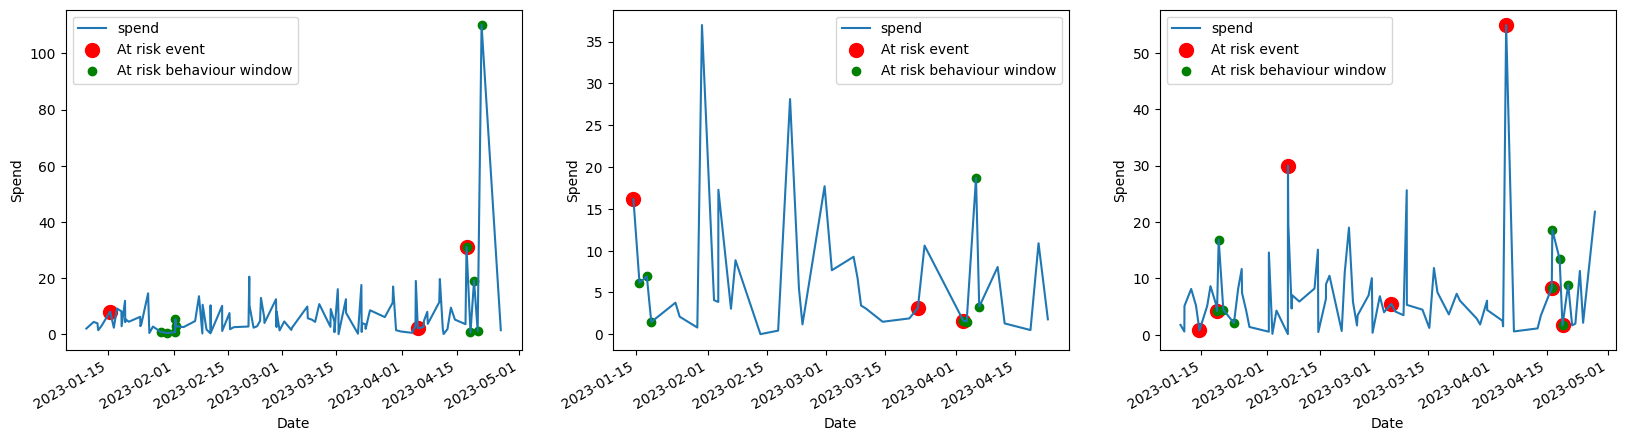

In [30]:
# plot id 1, 100, 1734
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot_anom(df=df, id=1, ax=ax[0])
plot_anom(df=df, id=100, ax=ax[1], legend_loc='best')
plot_anom(df=df, id=1734, ax=ax[2])

## Department Effect

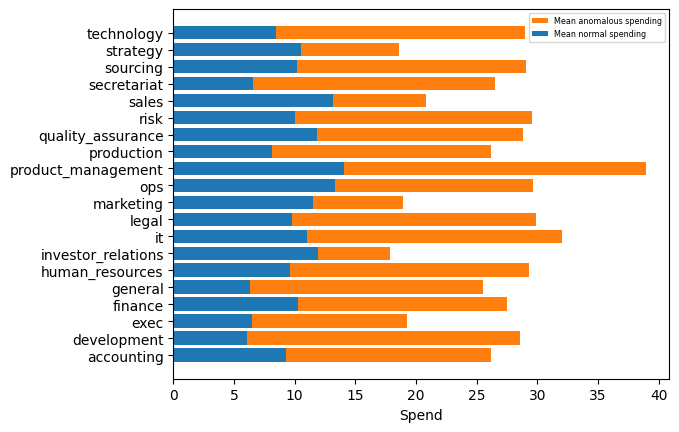

In [199]:
# mean spending per department
anom_dep = anomaly_df.groupby('department')['spend'].mean()
non_anom_dep = non_anomaly_df.groupby('department')['spend'].mean()

# plot barplots
fig, ax = plt.subplots()
ax.barh(anom_dep.index, anom_dep, label = 'Mean anomalous spending', color = 'tab:orange')
ax.barh(non_anom_dep.index, non_anom_dep, label = 'Mean normal spending', color = 'tab:blue')
ax.set_xlabel('Spend')
ax.legend(fontsize = 'xx-small')

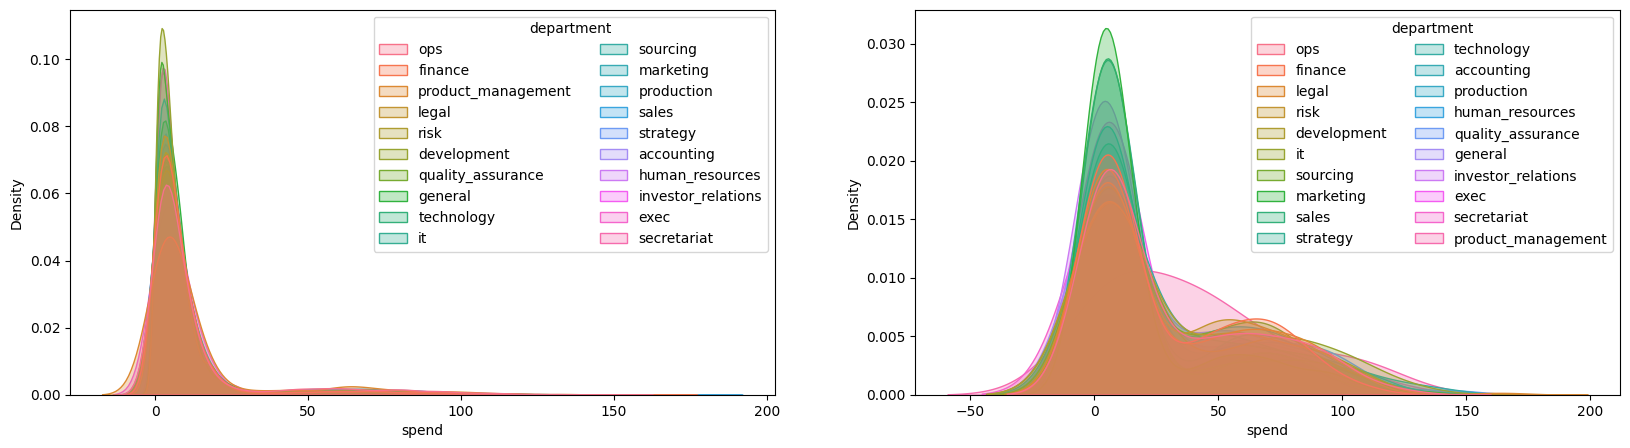

In [32]:
# plot kernel densities plot
fig, ax = plt.subplots(1,2, figsize=(20,5))
kde_normal = sns.kdeplot(data=non_anomaly_df, x="spend", hue="department", fill=True, common_norm=False, alpha=0.3, ax=ax[0])
sns.move_legend(kde_normal, "upper right", ncol=2)
kde_anom = sns.kdeplot(data=anomaly_df, x="spend", hue="department", fill=True, common_norm=False, alpha=0.3, ax=ax[1])
sns.move_legend(kde_anom, "upper right", ncol=2)

## Work Hour Effect

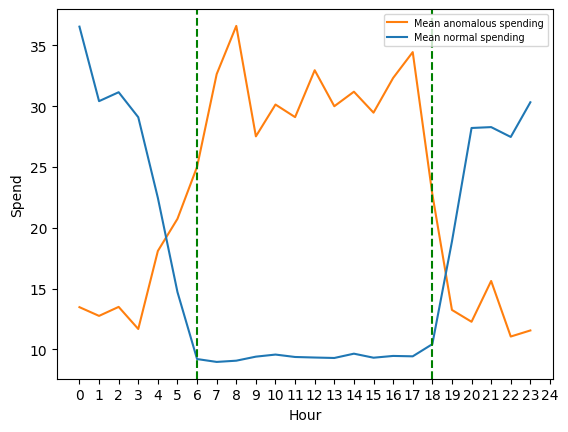

In [202]:
hour_spend = non_anomaly_df.groupby('hour')['spend'].mean()
anomaly_hour_spend = anomaly_df.groupby('hour')['spend'].mean()

# plot line plots
fig, ax = plt.subplots()
ax.plot(anomaly_hour_spend.index, anomaly_hour_spend, label = 'Mean anomalous spending', color = 'tab:orange')
ax.plot(hour_spend.index, hour_spend, label = 'Mean normal spending', color = 'tab:blue')
ax.set_xlabel('Hour')
ax.set_ylabel('Spend')
ax.set_xticks(list(range(0,25)))
ax.axvline(x=6, linestyle="dashed", color = 'green')
ax.axvline(x=18, linestyle="dashed", color = 'green')
ax.legend(loc = 'upper right', fontsize = 'x-small')

## Weekend effect

In [34]:
# high proportion of anomalies are in weekend
weekend_filter = df['weekend'] == 1

# number of transactions
num_weekend = sum(df['weekend'])
num_weekday = sum(df['weekend'] == 0)

# number of anomalies
num_anom_weekend = sum(df.loc[weekend_filter, 'at_risk_event'])
num_anom_weekdays = sum(df.loc[~weekend_filter, 'at_risk_event'])

weekend_stats = pd.DataFrame(
    {
        'Weekend': ['weekend', 'weekday'],
        'Number of transactions': [num_weekend, num_weekday],
        'Number of anomalies': [num_anom_weekend, num_anom_weekdays]
    }
)

weekend_stats['Anomaly proportion'] = weekend_stats['Number of anomalies']/weekend_stats['Number of transactions']


In [35]:
print(f'{num_anom_weekend/(num_anom_weekend+num_anom_weekdays)} of anomalies happen in the weekend')
weekend_stats

0.49548899314326955 of anomalies happen in the weekend


,Weekend,Number of transactions,Number of anomalies,Anomaly proportion
0,weekend,5222.0,1373,0.262926
1,weekday,100055.0,1398,0.013972


In [36]:
# check if first weekend spending always anomalies
# check proportion of weekend anomalies with duration between weekend anomalies more than 1 month

# get weekend data
weekend_df = df.loc[df['weekend'] == 1, ['individual_id','time','at_risk_event']]
id_list = pd.unique(weekend_df['individual_id'])

diff_list_all = []
first_weekend_is_anomaly_all = []

# call check_weekend_anom() across all id and concatenate results
for idx, id in enumerate(id_list):
    diff_list, first_weekend_is_anomaly = check_weekend_anom(weekend_df, id)
    diff_list_all += diff_list
    first_weekend_is_anomaly_all += first_weekend_is_anomaly

In [37]:
print(f'probability that the first weekend is an anomaly is {np.mean(first_weekend_is_anomaly)}')
print(f'probability that subsequent weekend is an anomaly given that 1 month has passed\
 after the previous weekend activity is {np.mean(np.array(diff_list_all) >= 34)}')

probability that the first weekend is an anomaly is 1.0
probability that subsequent weekend is an anomaly given that 1 month has passed after the previous weekend activity is 0.8603174603174604


Mode of the number of days between two weekend anomalies is 34


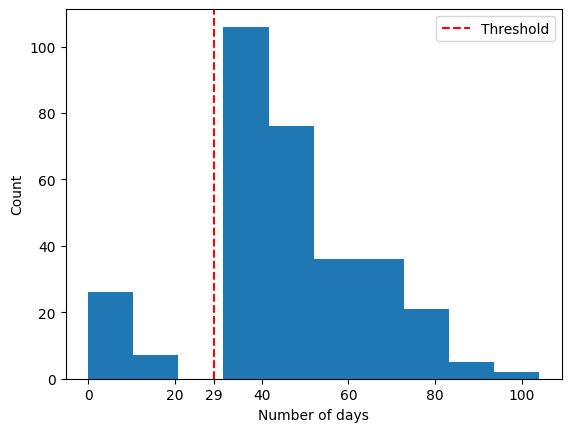

In [38]:
# distribution of the duration between consecutive weekend anomalies
fig,ax = plt.subplots()
ax.hist(diff_list_all)
ax.axvline(x = 29, linestyle = 'dashed', color = 'red', label = 'Threshold')

ax.set_xlabel('Number of days')
ax.set_ylabel('Count')
ax.set_xticks([0,20,29,40,60,80,100])
ax.legend()
print(f'Mode of the number of days between two weekend anomalies is {mode(diff_list_all)[0]}')

If an anomaly occurs in less than 29 days, it is simply because the activity it self is an anomaly, not because of the weekend effect

# Persistence Model (Baseline Model)
predicted value = previous value, i.e., naive prediction

In [39]:
# generate data
trainX, trainY, true_flag, true_id = gen_base_data(df_train)
testX, testY, true_flag_test, true_id_test = gen_base_data(df_test)

In [40]:
# prediction
y_train_pred = persist_model(trainX)
y_test_pred = persist_model(testX)

(array([2.7046e+04, 2.2650e+03, 6.7500e+02, 4.8100e+02, 3.6900e+02,
        2.1400e+02, 1.3100e+02, 5.9000e+01, 1.5000e+01, 6.0000e+00]),
 array([0.        , 0.82057306, 1.64114611, 2.46171917, 3.28229222,
        4.10286528, 4.92343833, 5.74401139, 6.56458444, 7.3851575 ,
        8.20573055]),
 <BarContainer object of 10 artists>)

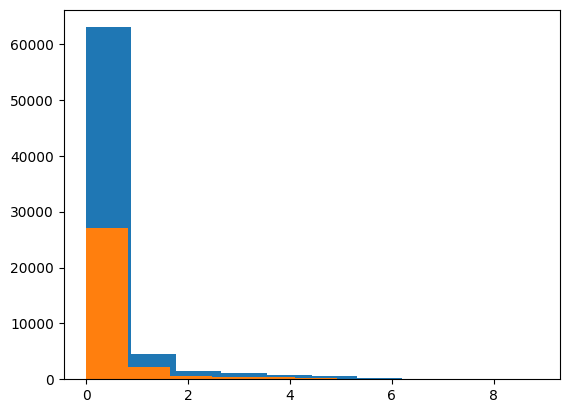

In [41]:
# absolute error
trainMAE_base = np.abs(y_train_pred - trainY)
testMAE_base = np.abs(y_test_pred - testY)
plt.hist(trainMAE_base)
plt.hist(testMAE_base)

### Simple Threshold

In [42]:
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(q_list):
    # risk event
    pred_flag_simple = gen_simple_flag(trainMAE_base, true_id, df_train, quantile = item)
    f1_event = perf_nofit(y_pred = pred_flag_simple, y_test = y1, print_=False)['f1']

    # risk window
    df_final['final_flag'] = pred_flag_simple.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    
    f1_list_event.append(f1_event)
    f1_list_window.append(f1_window)

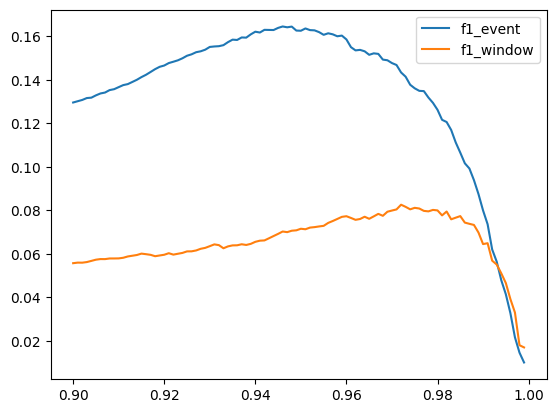

In [43]:
# check that optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()
best_q1_base = q_list[np.argmax(f1_list_event)]
best_q1_base_window = q_list[np.argmax(f1_list_window)]

#### RISK EVENT

In [44]:
# check performance with optimal parameters
# training data
print(f'best q for risk event is {best_q1_base}')
pred_flag_simple = gen_simple_flag(trainMAE_base, true_id, df_train, quantile = best_q1_base)
perf_nofit(pred_flag_simple, y1)

best q for risk event is 0.9460000000000001

Confusion Matrix:
 [[68051  3403]
 [ 1431   476]]

Recall (True Positive Rate): 0.2496
False Negative Rate: 0.7504
True Negative Rate: 0.9524
False Positive Rate: 0.0476
Precision: 0.1227
f1: 0.1645


{'FP': 3403,
 'TN': 68051,
 'TP': 476,
 'FN': 1431,
 'Recall': 0.2496067121132669,
 'FNR': 0.7503932878867331,
 'TNR': 0.9523749545161923,
 'FPR': 0.04762504548380776,
 'Precision': 0.12271203918535704,
 'f1': 0.16453508468717593}

In [45]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE_base, true_id_test, df_test, quantile = best_q1_base)
perf_nofit(pred_flag_simple_test, y1_test)


Confusion Matrix:
 [[29591  1461]
 [  636   228]]

Recall (True Positive Rate): 0.2639
False Negative Rate: 0.7361
True Negative Rate: 0.9529
False Positive Rate: 0.0471
Precision: 0.135
f1: 0.1786


{'FP': 1461,
 'TN': 29591,
 'TP': 228,
 'FN': 636,
 'Recall': 0.2638888888888889,
 'FNR': 0.7361111111111112,
 'TNR': 0.9529498905062476,
 'FPR': 0.047050109493752414,
 'Precision': 0.1349911190053286,
 'f1': 0.17861339600470033}

#### RISK WINDOW

In [46]:
# check performance with optimal parameters
# train data
print(f'best_q for window is {best_q1_base_window}')
pred_flag_simple = gen_simple_flag(trainMAE_base, true_id, df_train, quantile = best_q1_base_window)
df_final['final_flag'] = pred_flag_simple.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.972
precision: 0.054865424430641824 recall: 0.167192429022082 f1: 0.08261886204208885


In [47]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE_base, true_id_test, df_test, quantile = best_q1_base_window)
df_final_test['final_flag'] = pred_flag_simple_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.05555555555555555 recall: 0.1709090909090909 f1: 0.08385370205173952


# LSTM

## Univariate LSTM

In [157]:
# Generate Input Data
X_lstm = X.drop(['minute_passed'], axis = 1)
X_lstm_test = X_test.drop(['minute_passed'], axis = 1)

trainX, trainY, true_flag, true_dep, true_weekend_flag, true_id, true_time = gen_train_lstm(X_lstm, df, n_future = 1, n_past = 5, univariate = True)
testX, testY, true_flag_test, true_dep_test, true_weekend_flag_test, true_id_test, true_time_test = gen_train_lstm(X_lstm_test, df, n_future = 1, n_past = 5, univariate = True)

train_flag = df_train['at_risk_event']
test_flag = df_test['at_risk_event']

trainX shape == (65904, 5, 1).
trainY shape == (65904, 1).
true_flag shape == (65904,).
true_dep shape == (65904,).
true_weekend_flag shape == (65904,).
true_id shape == (65904,).
trainX shape == (28705, 5, 1).
trainY shape == (28705, 1).
true_flag shape == (28705,).
true_dep shape == (28705,).
true_weekend_flag shape == (28705,).
true_id shape == (28705,).


In [203]:
# define the model
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5, activation='relu', return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Frans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 5, 5)           │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366 (1.43 KB)

 Trainable params: 366 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
tf.keras.utils.set_random_seed(89) 
tf.config.experimental.enable_op_determinism()

# to get predicitons from each epoch
predictions=prediction_for_each_epoch()

# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_split=0.1, verbose=1, callbacks=[predictions], shuffle=False)

Epoch 1/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8405 - val_loss: 0.4637
Epoch 2/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 733us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5712 - val_loss: 0.4611
Epoch 3/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5558 - val_loss: 0.4564
Epoch 4/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5528 - val_loss: 0.4565
Epoch 5/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5498 - val_loss: 0.4587


2060/2060 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step


(array([1.7439e+04, 7.3680e+03, 1.2330e+03, 6.0900e+02, 3.2000e+02,
        2.0900e+02, 1.9400e+02, 2.1300e+02, 2.8300e+02, 3.1600e+02,
        1.6300e+02, 7.8000e+01, 6.4000e+01, 4.5000e+01, 3.8000e+01,
        3.3000e+01, 2.7000e+01, 2.0000e+01, 1.6000e+01, 8.0000e+00,
        4.0000e+00, 8.0000e+00, 1.2000e+01, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.64652876e-04, 2.64219345e-01, 5.28174038e-01, 7.92128730e-01,
        1.05608342e+00, 1.32003811e+00, 1.58399281e+00, 1.84794750e+00,
        2.11190219e+00, 2.37585688e+00, 2.63981158e+00, 2.90376627e+00,
        3.16772096e+00, 3.43167565e+00, 3.69563035e+00, 3.95958504e+00,
        4.22353973e+00, 4.48749442e+00, 4.75144912e+00, 5.01540381e+00,
        5.27935850e+00, 5.54331319e+00, 5.80726788e+00, 6.07122258e+00,
        6.33517727e+00, 6.59913196e+00, 6.86308665e+00, 7.12704135e+00,
        7.39099604e+00, 7.65495073e+00, 7.91890542e+00]),
 <BarContainer object of 30 

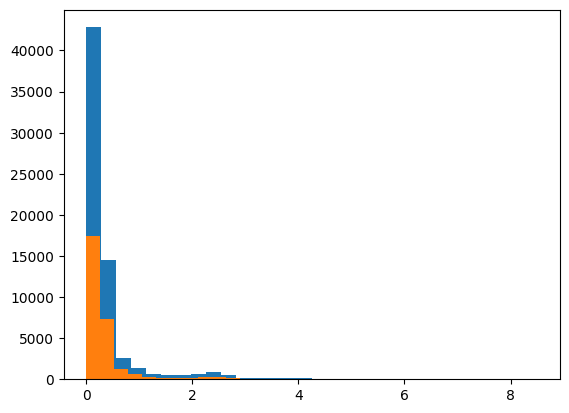

In [205]:
# get errors
trainPredict = model.predict(trainX)
trainMAE = np.abs(trainPredict - trainY).ravel()
plt.hist(trainMAE, bins=30)

testPredict = model.predict(testX)
testMAE = np.abs(testPredict - testY).ravel()
plt.hist(testMAE, bins=30)

### Simple Threshold

In [226]:
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(q_list):
    # risk event
    pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = item)
    f1_event = perf_nofit(y_pred = pred_flag_simple, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_simple.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

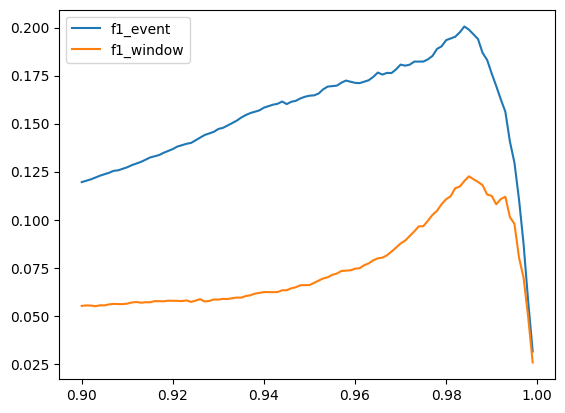

In [227]:
# see that optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q1 = q_list[np.argmax(f1_list_event)]
best_q1_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [228]:
# check performance with optimal parameters
# training data
print(f'best_q is {best_q1}')
pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = best_q1)
perf_nofit(y_pred = pred_flag_simple, y_test = train_flag)

best_q is 0.984

Confusion Matrix:
 [[70696   758]
 [ 1610   297]]

Recall (True Positive Rate): 0.1557
False Negative Rate: 0.8443
True Negative Rate: 0.9894
False Positive Rate: 0.0106
Precision: 0.2815
f1: 0.2005


{'FP': 758,
 'TN': 70696,
 'TP': 297,
 'FN': 1610,
 'Recall': 0.1557420031463031,
 'FNR': 0.844257996853697,
 'TNR': 0.9893917765275562,
 'FPR': 0.01060822347244381,
 'Precision': 0.28151658767772514,
 'f1': 0.20054017555705606}

In [229]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, true_id_test, df_test, quantile = best_q1)
perf_nofit(y_pred = pred_flag_simple_test, y_test = test_flag)


Confusion Matrix:
 [[30723   329]
 [  733   131]]

Recall (True Positive Rate): 0.1516
False Negative Rate: 0.8484
True Negative Rate: 0.9894
False Positive Rate: 0.0106
Precision: 0.2848
f1: 0.1979


{'FP': 329,
 'TN': 30723,
 'TP': 131,
 'FN': 733,
 'Recall': 0.15162037037037038,
 'FNR': 0.8483796296296297,
 'TNR': 0.989404869251578,
 'FPR': 0.010595130748422003,
 'Precision': 0.2847826086956522,
 'f1': 0.19788519637462237}

#### Risk Window

In [230]:
# train data
print(f'best_q for window is {best_q1_window}')
pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = best_q1_window)
df_final['final_flag'] = pred_flag_simple.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.985
precision: 0.10155440414507771 recall: 0.15457413249211358 f1: 0.12257661038148844


In [231]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, true_id_test, df_test, quantile = best_q1_window)
df_final_test['final_flag'] = pred_flag_simple_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.10952380952380952 recall: 0.16727272727272727 f1: 0.13237410071942446


### Threshold by Department

In [232]:
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []
for idx, item in enumerate(q_list):
    # risk event
    pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = item)
    f1_event= perf_nofit(y_pred = pred_flag_dep, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    # risk window
    df_final['final_flag'] = pred_flag_dep.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

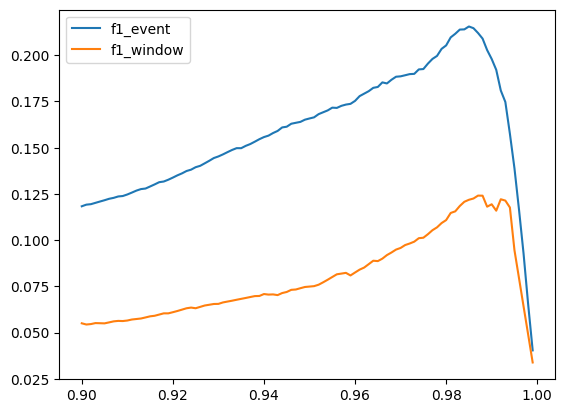

In [234]:
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q2 = q_list[np.argmax(f1_list_event)]
best_q2_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [235]:
# train data
print(f'best_q for risk event is {best_q2}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = best_q2)
perf_nofit(y_pred = pred_flag_dep, y_test = train_flag)

best_q for risk event is 0.985

Confusion Matrix:
 [[70770   684]
 [ 1594   313]]

Recall (True Positive Rate): 0.1641
False Negative Rate: 0.8359
True Negative Rate: 0.9904
False Positive Rate: 0.0096
Precision: 0.3139
f1: 0.2156


{'FP': 684,
 'TN': 70770,
 'TP': 313,
 'FN': 1594,
 'Recall': 0.1641321447299423,
 'FNR': 0.8358678552700577,
 'TNR': 0.9904274078428079,
 'FPR': 0.00957259215719204,
 'Precision': 0.3139418254764293,
 'f1': 0.21556473829201103}

In [236]:
# test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, true_id_test, df_test, quantile = best_q2)
perf_nofit(y_pred = pred_flag_dep_test, y_test = df_test['at_risk_event'])


Confusion Matrix:
 [[30746   306]
 [  730   134]]

Recall (True Positive Rate): 0.1551
False Negative Rate: 0.8449
True Negative Rate: 0.9901
False Positive Rate: 0.0099
Precision: 0.3045
f1: 0.2055


{'FP': 306,
 'TN': 30746,
 'TP': 134,
 'FN': 730,
 'Recall': 0.1550925925925926,
 'FNR': 0.8449074074074074,
 'TNR': 0.9901455622826227,
 'FPR': 0.009854437717377302,
 'Precision': 0.30454545454545456,
 'f1': 0.20552147239263807}

#### Risk Window

In [237]:
# train data
print(f'best_q for window is {best_q2_window}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = best_q2_window)
df_final['final_flag'] = pred_flag_dep.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.987
precision: 0.10836277974087162 recall: 0.14511041009463724 f1: 0.12407282535401215


In [238]:
# Test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, true_id_test, df_test, quantile = best_q2_window)
df_final_test['final_flag'] = pred_flag_dep_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.12365591397849462 recall: 0.16727272727272727 f1: 0.14219474497681608


### Dynamic Threshold

In [206]:
# Grid search for best beta
beta_list = np.array(range(200, 400))
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(beta_list):
    # risk event
    pred_flag_struct, cut_flag_struct = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=item)
    f1_event = perf_nofit(y_pred = pred_flag_struct, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_struct.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

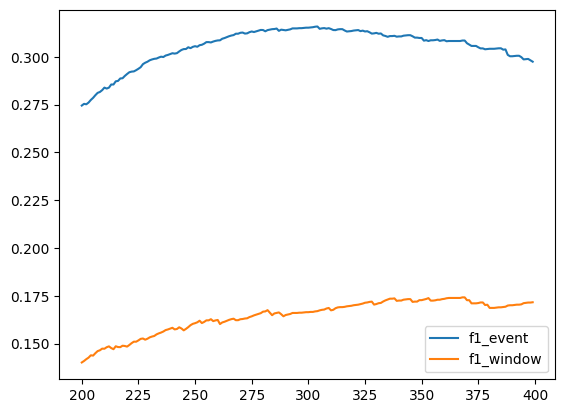

In [207]:
# optimal value reached
plt.plot(beta_list, f1_list_event,  label="f1_event")
plt.plot(beta_list, f1_list_window,  label="f1_window")
plt.legend()

best_beta_uni = beta_list[np.argmax(f1_list_event)]
best_beta_uni_window = beta_list[np.argmax(f1_list_window)]


#### Risk Event

In [208]:
# train data
print(f'best beta is {best_beta_uni}')
pred_flag_struct_event, cut_flag_struct_event = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=best_beta_uni)
perf_nofit(y_pred = pred_flag_struct_event, y_test = train_flag)

best beta is 304

Confusion Matrix:
 [[71255   199]
 [ 1512   395]]

Recall (True Positive Rate): 0.2071
False Negative Rate: 0.7929
True Negative Rate: 0.9972
False Positive Rate: 0.0028
Precision: 0.665
f1: 0.3159


{'FP': 199,
 'TN': 71255,
 'TP': 395,
 'FN': 1512,
 'Recall': 0.20713162034609334,
 'FNR': 0.7928683796539067,
 'TNR': 0.9972149914630392,
 'FPR': 0.002785008536960842,
 'Precision': 0.664983164983165,
 'f1': 0.3158736505397841}

In [209]:
# for test data
pred_flag_struct_test_event, cut_flag_struct_test_event = gen_struct_flag(predictions, testY, true_id_test, df_test, training=False, beta=best_beta_uni)
perf_nofit(y_pred = pred_flag_struct_test_event, y_test = test_flag)


Confusion Matrix:
 [[30965    87]
 [  689   175]]

Recall (True Positive Rate): 0.2025
False Negative Rate: 0.7975
True Negative Rate: 0.9972
False Positive Rate: 0.0028
Precision: 0.6679
f1: 0.3108


{'FP': 87,
 'TN': 30965,
 'TP': 175,
 'FN': 689,
 'Recall': 0.2025462962962963,
 'FNR': 0.7974537037037037,
 'TNR': 0.9971982480999614,
 'FPR': 0.002801751900038645,
 'Precision': 0.6679389312977099,
 'f1': 0.3108348134991119}

#### Risk Window

In [210]:
# train data
print(f'best beta for window is {best_beta_uni_window}')
pred_flag_struct_window, cut_flag_struct_window = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=best_beta_uni_window)
df_final['final_flag'] = pred_flag_struct_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best beta for window is 368
precision: 0.20208333333333334 recall: 0.1529968454258675 f1: 0.17414721723518853


In [211]:
# Test data
pred_flag_struct_test_window, cut_flag_struct_test_window = gen_struct_flag(predictions, testY, true_id_test, df_test, training=False, beta=best_beta_uni_window)
df_final_test['final_flag'] = pred_flag_struct_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.17209302325581396 recall: 0.13454545454545455 f1: 0.1510204081632653


### Post-processing

#### Pruning False Positives

In [212]:
# prune FP 
# structure threshold

# grid search to see best p and delta
p_list = np.arange(0.01, 0.2, 0.01)
delta_t_list = np.array(range(1,11)) # cooling period

f1_matrix = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t
f1_matrix_window = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t

for i, p in enumerate(p_list):
    for j, delta_t in enumerate(delta_t_list):
        # risk event
        pred_flag_mod_event = gen_full_flag_pruned(cut_flag_struct_event, true_id, df_train, trainMAE, true_time, p, delta_t)
        f1_event = perf_nofit(y_pred = pred_flag_mod_event, y_test = train_flag, print_=False)['f1']
        f1_matrix[i,j] = f1_event

        # risk window
        pred_flag_mod_window = gen_full_flag_pruned(cut_flag_struct_window, true_id, df_train, trainMAE, true_time, p, delta_t)
        df_final['final_flag'] = pred_flag_mod_window.astype('bool')
        df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
        f1_matrix_window[i,j] = f1_window

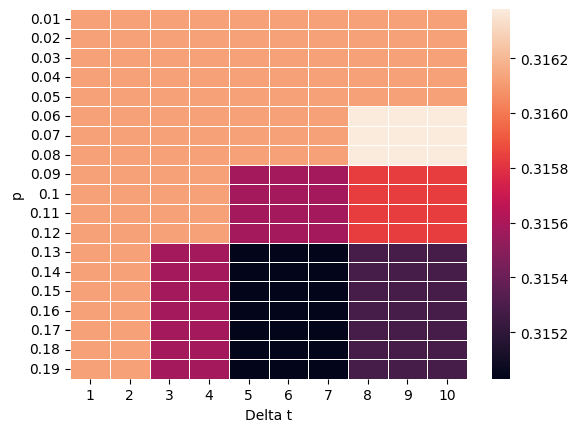

In [213]:
# check that optimal value was reached
# risk event
ax = sns.heatmap(f1_matrix, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

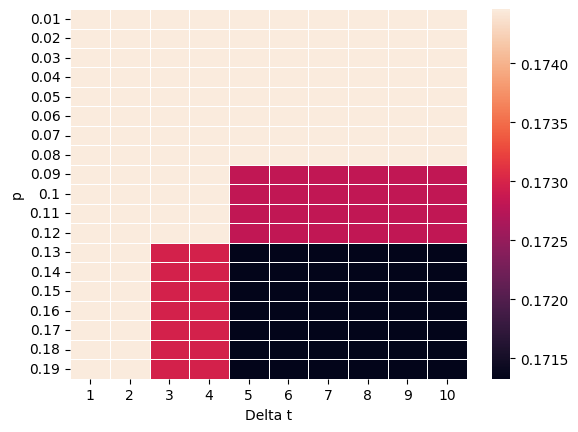

In [214]:
# check optimal value was reached
# risk behaviour window
ax1 = sns.heatmap(f1_matrix_window, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax1.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

##### Risk Event

In [215]:
# get best parameter and construct updated flags
# risk event
indices_event = np.where(f1_matrix == f1_matrix.max())
best_p_uni = np.round(p_list[indices_event[0][0]],2)
best_delta_t_uni = delta_t_list[indices_event[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_uni} or occur within less than {best_delta_t_uni} days.')

# train data
pred_flag_struct_mod_event = gen_full_flag_pruned(cut_flag_struct_event, true_id, df_train, trainMAE, true_time, best_p_uni, best_delta_t_uni)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_event, y_test = train_flag)

Prune FP if consecutive anomalies has difference less than 0.06 or occur within less than 8 days.

Confusion Matrix:
 [[71259   195]
 [ 1512   395]]

Recall (True Positive Rate): 0.2071
False Negative Rate: 0.7929
True Negative Rate: 0.9973
False Positive Rate: 0.0027
Precision: 0.6695
f1: 0.3164


{'FP': 195,
 'TN': 71259,
 'TP': 395,
 'FN': 1512,
 'Recall': 0.20713162034609334,
 'FNR': 0.7928683796539067,
 'TNR': 0.9972709715341338,
 'FPR': 0.0027290284658661517,
 'Precision': 0.6694915254237288,
 'f1': 0.316379655586704}

In [216]:
# test data
pred_flag_struct_mod_test_event = gen_full_flag_pruned(cut_flag_struct_test_event, true_id_test, df_test, testMAE, true_time_test, best_p_uni, best_delta_t_uni)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_test_event, y_test = test_flag)


Confusion Matrix:
 [[30965    87]
 [  689   175]]

Recall (True Positive Rate): 0.2025
False Negative Rate: 0.7975
True Negative Rate: 0.9972
False Positive Rate: 0.0028
Precision: 0.6679
f1: 0.3108


{'FP': 87,
 'TN': 30965,
 'TP': 175,
 'FN': 689,
 'Recall': 0.2025462962962963,
 'FNR': 0.7974537037037037,
 'TNR': 0.9971982480999614,
 'FPR': 0.002801751900038645,
 'Precision': 0.6679389312977099,
 'f1': 0.3108348134991119}

##### Risk Window

In [217]:
# get best parameter and construct updated flags
# risk event
indices_window = np.where(f1_matrix_window == f1_matrix_window.max())
best_p_uni_window = np.round(p_list[indices_window[0][0]],2)
best_delta_t_uni_window = delta_t_list[indices_window[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_uni} or occur within less than {best_delta_t_uni} days.')

# train data
pred_flag_struct_mod_window = gen_full_flag_pruned(cut_flag_struct_window, true_id, df_train, trainMAE, true_time, best_p_uni_window, best_delta_t_uni_window)
# evaluate performance
df_final['final_flag'] = pred_flag_struct_mod_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

Prune FP if consecutive anomalies has difference less than 0.06 or occur within less than 8 days.
precision: 0.20292887029288703 recall: 0.1529968454258675 f1: 0.1510204081632653


In [218]:
# test data
pred_flag_struct_mod_test_window = gen_full_flag_pruned(cut_flag_struct_test_window, true_id_test, df_test, testMAE, true_time_test, best_p_uni_window, best_delta_t_uni_window)
# evaluate performance
df_final_test['final_flag'] = pred_flag_struct_mod_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final_test,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.17209302325581396 recall: 0.13454545454545455 f1: 0.1510204081632653


#### Domain Knowledge: Weekend Effect

##### Risk Event

In [219]:
# training data
pred_flag_weekend_final = gen_flag_weekend_effect(pred_flag_struct_mod_event, df_train)
perf_nofit(y_pred = pred_flag_weekend_final, y_test = train_flag)


Confusion Matrix:
 [[71259   195]
 [  580  1327]]

Recall (True Positive Rate): 0.6959
False Negative Rate: 0.3041
True Negative Rate: 0.9973
False Positive Rate: 0.0027
Precision: 0.8719
f1: 0.774


{'FP': 195,
 'TN': 71259,
 'TP': 1327,
 'FN': 580,
 'Recall': 0.6958573675930781,
 'FNR': 0.30414263240692185,
 'TNR': 0.9972709715341338,
 'FPR': 0.0027290284658661517,
 'Precision': 0.8718791064388962,
 'f1': 0.773986585010207}

In [220]:
# test data
pred_flag_weekend_test_final = gen_flag_weekend_effect(pred_flag_struct_mod_test_event, df_test)
perf_nofit(y_pred = pred_flag_weekend_test_final, y_test = test_flag)


Confusion Matrix:
 [[30965    87]
 [  300   564]]

Recall (True Positive Rate): 0.6528
False Negative Rate: 0.3472
True Negative Rate: 0.9972
False Positive Rate: 0.0028
Precision: 0.8664
f1: 0.7446


{'FP': 87,
 'TN': 30965,
 'TP': 564,
 'FN': 300,
 'Recall': 0.6527777777777778,
 'FNR': 0.3472222222222222,
 'TNR': 0.9971982480999614,
 'FPR': 0.002801751900038645,
 'Precision': 0.8663594470046083,
 'f1': 0.7445544554455444}

##### Risk Window

In [221]:
# train data
pred_flag_weekend_final_window = gen_flag_weekend_effect(pred_flag_struct_window, df_train)
df_final['final_flag'] = pred_flag_weekend_final_window.astype('bool')
df_with_pred_evaluations_final, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.1279317697228145 recall: 0.28391167192429023 f1: 0.1763841254287114


In [222]:
# Test Data
pred_flag_weekend_final_test_window = gen_flag_weekend_effect(pred_flag_struct_test_window, df_test)
df_final_test['final_flag'] = pred_flag_weekend_final_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.13432835820895522 recall: 0.29454545454545455 f1: 0.1845102505694761


### Plot Predicted flags and real flags

In [223]:
# make data frame for plotting
df_plot = df_with_pred_evaluations_final.copy()
df_plot['pred_event_flag'] = pred_flag_weekend_final
df_plot['time'] = df_train['time']

# make list of tuple: (predicted flag, observed flag)
res_event = list(zip(pred_flag_weekend_final.astype(int), train_flag.astype(int)))

# dictionary for mapping tuples to confusion matrix label
mapping = {
    (0,0): 'TN',
    (0,1): 'FN',
    (1,1): 'TP',
    (1,0): 'FP',
}

# make confusion matrix label for each data point (for plotting risk event predictions)
confusion_event = [mapping[i] for i in res_event]
df_plot['confusion_event'] = confusion_event

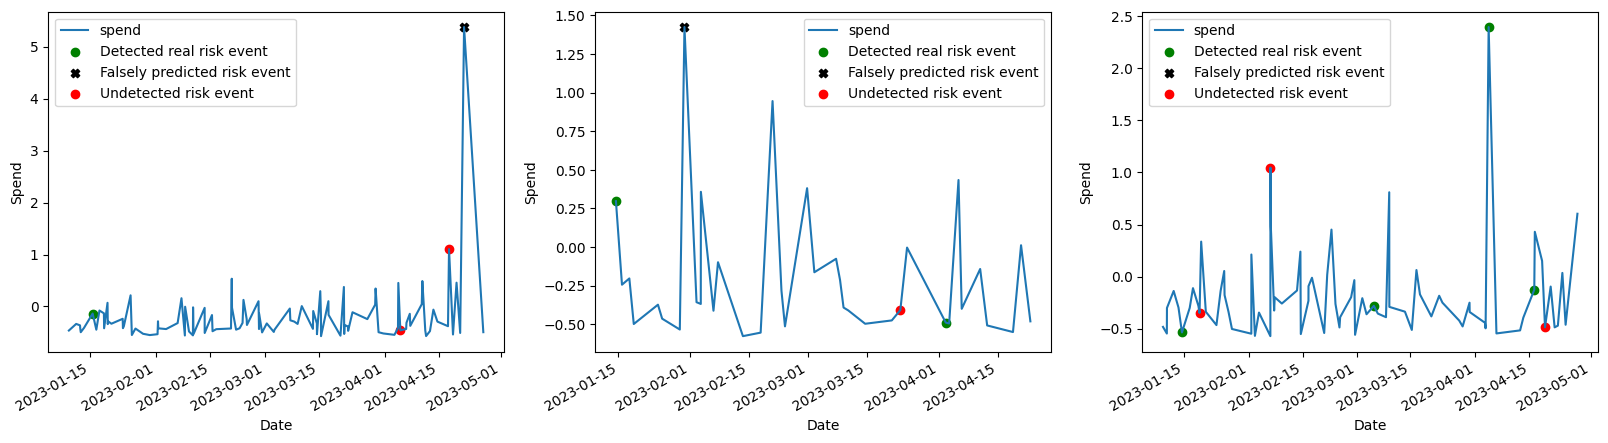

In [224]:
# plot risk event predictions
fig, ax = plt.subplots(1,3, figsize = (20,5))
plot_results(df_plot, 1, ax[0], True)
plot_results(df_plot, 100, ax[1], True, 'best')
plot_results(df_plot, 1734, ax[2], True)

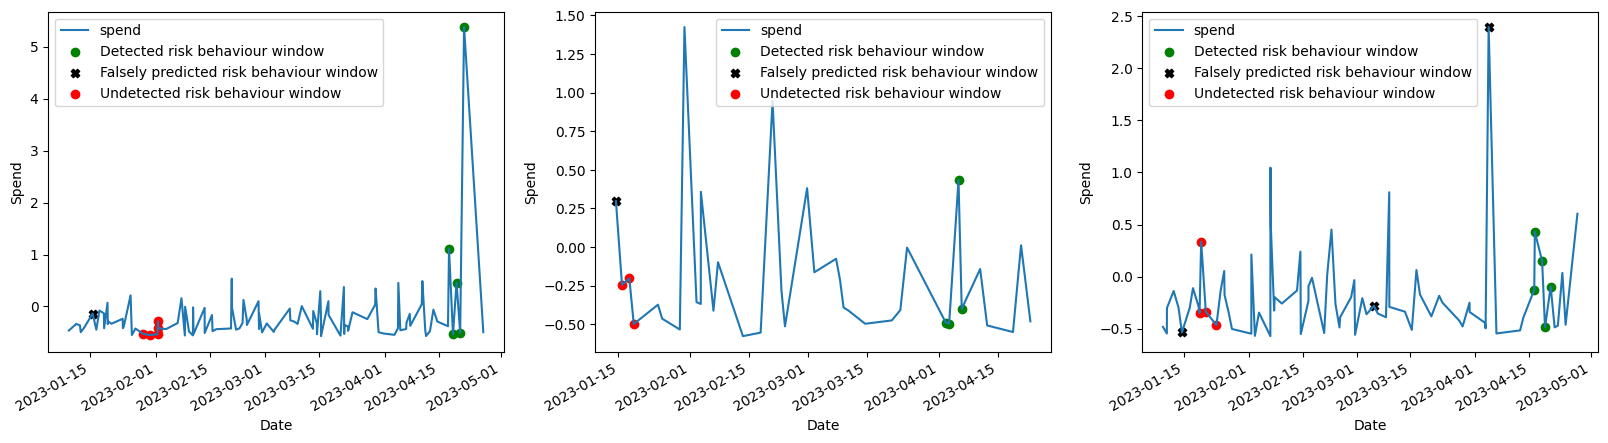

In [225]:
# plot risk behaviour window predictions
fig, ax = plt.subplots(1,3, figsize = (20,5))
plot_results(df_plot, 1, ax[0], False)
plot_results(df_plot, 100, ax[1], False, 'best')
plot_results(df_plot, 1734, ax[2], False)

## Multivariate LSTM
no significant improvement compared to univariate...

In [84]:
# set input matrix
# will always be dropped: id, deparment, time
ohe_col = X.columns[X.columns.str.startswith('department_')].to_list()
drop_col = ['minute_passed', 'unix'] + ohe_col
X_lstm = X.drop(drop_col, axis = 1)
X_lstm_test = X_test.drop(drop_col, axis = 1)
X_lstm

,individual_id,department,spend,time,work_hour,weekend,weekend_flag,time_diff
0,1,ops,-0.463358,2023-01-09 11:59:40.000,1.0,0.0,0.0,-0.677730
1,1,ops,-0.336158,2023-01-11 09:10:02.900,1.0,0.0,0.0,-0.062187
2,1,ops,-0.363763,2023-01-12 08:51:48.700,1.0,0.0,0.0,-0.354840
3,1,ops,-0.429799,2023-01-12 10:44:15.000,1.0,0.0,0.0,-0.652195
4,1,ops,-0.495834,2023-01-12 13:30:58.900,1.0,0.0,0.0,-0.639865
...,...,...,...,...,...,...,...,...
105272,2184,finance,-0.094749,2023-04-20 12:20:57.300,1.0,0.0,0.0,-0.358721
105273,2184,finance,0.518515,2023-04-21 10:12:27.800,1.0,0.0,0.0,-0.379879
105274,2184,finance,0.086037,2023-04-24 17:24:52.300,1.0,0.0,0.0,0.401570
105275,2185,investor_relations,0.271694,2023-02-08 12:50:15.000,1.0,0.0,0.0,-0.677730


In [85]:
# construct data
trainX, trainY, true_flag, true_dep, true_weekend_flag, true_id, true_time = gen_train_lstm(X_lstm, df, n_future = 1, n_past = 5, univariate = False)
testX, testY, true_flag_test, true_dep_test, true_weekend_flag_test, true_id_test, true_time_test = gen_train_lstm(X_lstm_test, df, n_future = 1, n_past = 5, univariate = False)

trainX shape == (65904, 5, 5).
trainY shape == (65904, 1).
true_flag shape == (65904,).
true_dep shape == (65904,).
true_weekend_flag shape == (65904,).
true_id shape == (65904,).
trainX shape == (28705, 5, 5).
trainY shape == (28705, 1).
true_flag shape == (28705,).
true_dep shape == (28705,).
true_weekend_flag shape == (28705,).
true_id shape == (28705,).


In [86]:
# define the model
model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='relu', return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Frans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 25)          │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,226 (32.13 KB)

 Trainable params: 8,226 (32.13 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# to get predicitons from each epoch
tf.keras.utils.set_random_seed(1)
predictions=prediction_for_each_epoch()

# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_split=0.1, verbose=1, callbacks=[predictions])

Epoch 1/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6645 - val_loss: 0.4565
Epoch 2/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 768us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5692 - val_loss: 0.4511
Epoch 3/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5631 - val_loss: 0.4504
Epoch 4/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 771us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5578 - val_loss: 0.4489
Epoch 5/5
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5581 - val_loss: 0.4463


2060/2060 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step


(array([1.5625e+04, 9.2760e+03, 1.2010e+03, 6.1600e+02, 3.3300e+02,
        1.9100e+02, 1.6400e+02, 1.6300e+02, 2.4000e+02, 2.8600e+02,
        2.8000e+02, 6.2000e+01, 6.1000e+01, 5.3000e+01, 3.0000e+01,
        3.3000e+01, 2.1000e+01, 2.1000e+01, 1.5000e+01, 7.0000e+00,
        5.0000e+00, 7.0000e+00, 8.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.55958244e-06, 2.60649128e-01, 5.21293696e-01, 7.81938264e-01,
        1.04258283e+00, 1.30322740e+00, 1.56387197e+00, 1.82451654e+00,
        2.08516110e+00, 2.34580567e+00, 2.60645024e+00, 2.86709481e+00,
        3.12773938e+00, 3.38838394e+00, 3.64902851e+00, 3.90967308e+00,
        4.17031765e+00, 4.43096222e+00, 4.69160678e+00, 4.95225135e+00,
        5.21289592e+00, 5.47354049e+00, 5.73418506e+00, 5.99482962e+00,
        6.25547419e+00, 6.51611876e+00, 6.77676333e+00, 7.03740790e+00,
        7.29805246e+00, 7.55869703e+00, 7.81934160e+00]),
 <BarContainer object of 30 

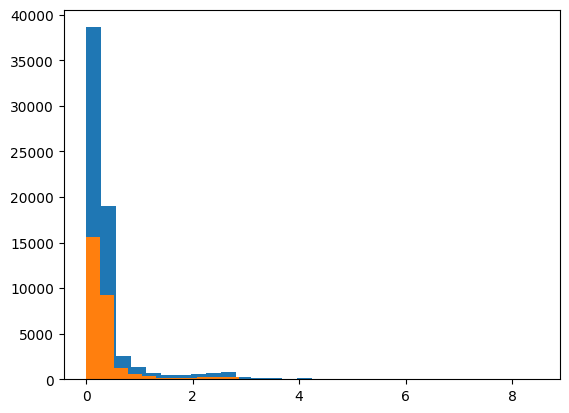

In [88]:
trainPredict = model.predict(trainX)

# trainMAE = np.mean(np.abs(trainPredict - X_train_id['spend'][3:].values.reshape(-1,1)), axis=1)
# trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
trainMAE = np.abs(trainPredict - trainY).ravel()
plt.hist(trainMAE, bins=30)

testPredict = model.predict(testX)
testMAE = np.abs(testPredict - testY).ravel()
plt.hist(testMAE, bins=30)

### Simple Threshold

In [89]:
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(q_list):
    # risk event
    pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = item)
    f1_event = perf_nofit(y_pred = pred_flag_simple, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_simple.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

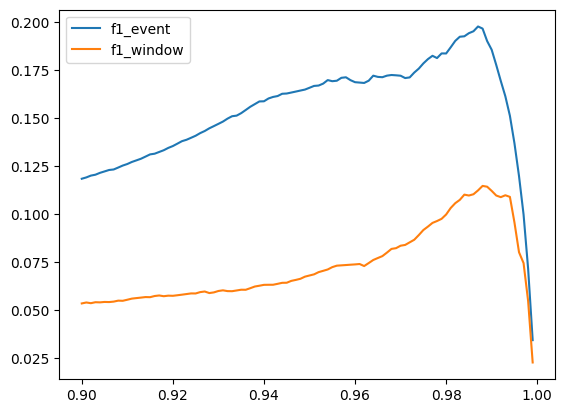

In [90]:
# check optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q1_multi = q_list[np.argmax(f1_list_event)]
best_q1_multi_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [91]:
# train data
print(f'best_q is {best_q1_multi}')
pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = best_q1_multi)
perf_nofit(y_pred = pred_flag_simple, y_test = train_flag)

best_q is 0.987

Confusion Matrix:
 [[70870   584]
 [ 1634   273]]

Recall (True Positive Rate): 0.1432
False Negative Rate: 0.8568
True Negative Rate: 0.9918
False Positive Rate: 0.0082
Precision: 0.3186
f1: 0.1975


{'FP': 584,
 'TN': 70870,
 'TP': 273,
 'FN': 1634,
 'Recall': 0.14315679077084426,
 'FNR': 0.8568432092291557,
 'TNR': 0.9918269096201752,
 'FPR': 0.008173090379824782,
 'Precision': 0.3185530921820303,
 'f1': 0.1975397973950796}

In [92]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, true_id_test, df_test, quantile = best_q1_multi)
perf_nofit(y_pred = pred_flag_simple_test, y_test = test_flag)


Confusion Matrix:
 [[30800   252]
 [  742   122]]

Recall (True Positive Rate): 0.1412
False Negative Rate: 0.8588
True Negative Rate: 0.9919
False Positive Rate: 0.0081
Precision: 0.3262
f1: 0.1971


{'FP': 252,
 'TN': 30800,
 'TP': 122,
 'FN': 742,
 'Recall': 0.1412037037037037,
 'FNR': 0.8587962962962963,
 'TNR': 0.9918845807033363,
 'FPR': 0.008115419296663661,
 'Precision': 0.32620320855614976,
 'f1': 0.19709208400646203}

#### Risk Window

In [93]:
# train data
print(f'best_q for window is {best_q1_multi_window}')
pred_flag_simple = gen_simple_flag(trainMAE, true_id, df_train, quantile = best_q1_multi_window)
df_final['final_flag'] = pred_flag_simple.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.988
precision: 0.10397946084724005 recall: 0.1277602523659306 f1: 0.11464968152866242


In [94]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, true_id_test, df_test, quantile = best_q1_multi_window)
df_final_test['final_flag'] = pred_flag_simple_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.12721893491124261 recall: 0.15636363636363637 f1: 0.14029363784665583


### Threshold by Department

In [95]:
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []
for idx, item in enumerate(q_list):
    # risk event
    pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = item)
    f1_event= perf_nofit(y_pred = pred_flag_dep, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    # risk window
    df_final['final_flag'] = pred_flag_dep.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

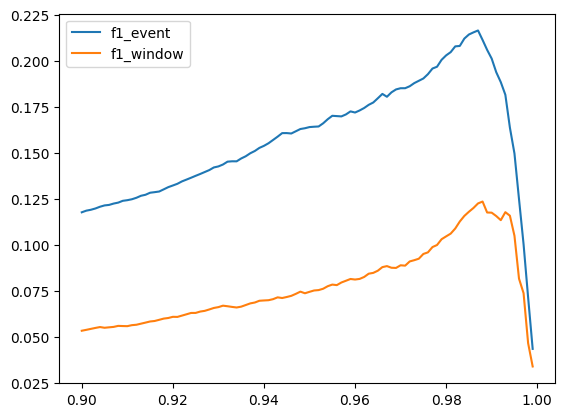

In [96]:
# check optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q2_multi = q_list[np.argmax(f1_list_event)]
best_q2_multi_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [97]:
# train data
print(f'best_q for risk event is {best_q2_multi}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = best_q2_multi)
perf_nofit(y_pred = pred_flag_dep, y_test = train_flag)

best_q for risk event is 0.987

Confusion Matrix:
 [[70888   566]
 [ 1607   300]]

Recall (True Positive Rate): 0.1573
False Negative Rate: 0.8427
True Negative Rate: 0.9921
False Positive Rate: 0.0079
Precision: 0.3464
f1: 0.2164


{'FP': 566,
 'TN': 70888,
 'TP': 300,
 'FN': 1607,
 'Recall': 0.15731515469323545,
 'FNR': 0.8426848453067646,
 'TNR': 0.9920788199401013,
 'FPR': 0.007921180059898676,
 'Precision': 0.3464203233256351,
 'f1': 0.21637216011539848}

In [98]:
# test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, true_id_test, df_test, quantile = best_q2_multi)
perf_nofit(y_pred = pred_flag_dep_test, y_test = df_test['at_risk_event'])


Confusion Matrix:
 [[30793   259]
 [  739   125]]

Recall (True Positive Rate): 0.1447
False Negative Rate: 0.8553
True Negative Rate: 0.9917
False Positive Rate: 0.0083
Precision: 0.3255
f1: 0.2003


{'FP': 259,
 'TN': 30793,
 'TP': 125,
 'FN': 739,
 'Recall': 0.14467592592592593,
 'FNR': 0.8553240740740741,
 'TNR': 0.9916591523895402,
 'FPR': 0.008340847610459874,
 'Precision': 0.3255208333333333,
 'f1': 0.20032051282051283}

#### Risk Window

In [99]:
# train data
print(f'best_q for window is {best_q2_multi_window}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, true_id, df_train, quantile = best_q2_multi_window)
df_final['final_flag'] = pred_flag_dep.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.988
precision: 0.1111111111111111 recall: 0.138801261829653 f1: 0.12342215988779803


In [100]:
# Test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, true_id_test, df_test, quantile = best_q2_multi_window)
df_final_test['final_flag'] = pred_flag_dep_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.12103746397694524 recall: 0.15272727272727274 f1: 0.13504823151125403


### Dynamic Threshold

In [101]:
# Grid search for best beta
beta_list = np.array(range(200, 400)) 
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(beta_list):
    # risk event
    pred_flag_struct, cut_flag_struct = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=item)
    f1_event = perf_nofit(y_pred = pred_flag_struct, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_struct.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

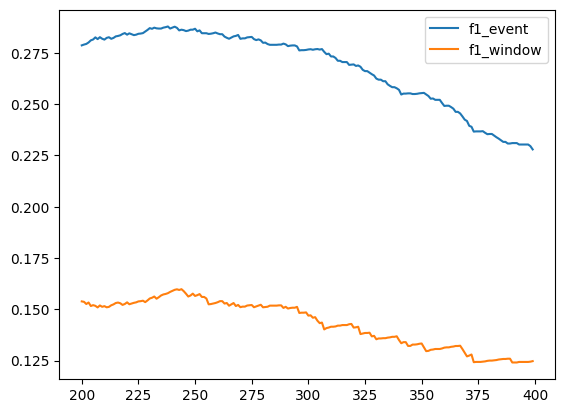

In [102]:
# check optimal value was reached
plt.plot(beta_list, f1_list_event,  label="f1_event")
plt.plot(beta_list, f1_list_window,  label="f1_window")
plt.legend()

best_beta_multi = beta_list[np.argmax(f1_list_event)]
best_beta_multi_window = beta_list[np.argmax(f1_list_window)]


#### Risk Event

In [103]:
# train data
print(f'best beta is {best_beta_uni}')
pred_flag_struct_event, cut_flag_struct_event = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=best_beta_multi)
perf_nofit(y_pred = pred_flag_struct_event, y_test = train_flag)

best beta is 200

Confusion Matrix:
 [[71184   270]
 [ 1541   366]]

Recall (True Positive Rate): 0.1919
False Negative Rate: 0.8081
True Negative Rate: 0.9962
False Positive Rate: 0.0038
Precision: 0.5755
f1: 0.2878


{'FP': 270,
 'TN': 71184,
 'TP': 366,
 'FN': 1541,
 'Recall': 0.19192448872574724,
 'FNR': 0.8080755112742527,
 'TNR': 0.9962213452011084,
 'FPR': 0.0037786547988915946,
 'Precision': 0.5754716981132075,
 'f1': 0.2878489972473457}

In [104]:
# for test data
pred_flag_struct_test_event, cut_flag_struct_test_event = gen_struct_flag(predictions, testY, true_id_test, df_test, training=False, beta=best_beta_multi)
perf_nofit(y_pred = pred_flag_struct_test_event, y_test = test_flag)


Confusion Matrix:
 [[30914   138]
 [  695   169]]

Recall (True Positive Rate): 0.1956
False Negative Rate: 0.8044
True Negative Rate: 0.9956
False Positive Rate: 0.0044
Precision: 0.5505
f1: 0.2886


{'FP': 138,
 'TN': 30914,
 'TP': 169,
 'FN': 695,
 'Recall': 0.19560185185185186,
 'FNR': 0.8043981481481481,
 'TNR': 0.9955558418137318,
 'FPR': 0.0044441581862681954,
 'Precision': 0.5504885993485342,
 'f1': 0.2886421861656704}

#### Risk Window

In [105]:
# train data
print(f'best beta for window is {best_beta_uni_window}')
pred_flag_struct_window, cut_flag_struct_window = gen_struct_flag(predictions, trainY, true_id, df_train, training = True, beta=best_beta_multi_window)
df_final['final_flag'] = pred_flag_struct_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best beta for window is 200
precision: 0.16363636363636364 recall: 0.15615141955835962 f1: 0.15980629539951574


In [106]:
# Test data
pred_flag_struct_test_window, cut_flag_struct_test_window = gen_struct_flag(predictions, testY, true_id_test, df_test, training=False, beta=best_beta_multi_window)
df_final_test['final_flag'] = pred_flag_struct_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.16326530612244897 recall: 0.17454545454545456 f1: 0.1687170474516696


### Post-processing

#### Pruning False Positives
not that great

In [107]:
# prune FP 
# structure threshold

# grid search to see best p and delta
p_list = np.arange(0.01, 0.2, 0.01)
delta_t_list = np.array(range(1,11)) # cooling period

f1_matrix = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t
f1_matrix_window = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t

for i, p in enumerate(p_list):
    for j, delta_t in enumerate(delta_t_list):
        # risk event
        pred_flag_mod_event = gen_full_flag_pruned(cut_flag_struct_event, true_id, df_train, trainMAE, true_time, p, delta_t)
        f1_event = perf_nofit(y_pred = pred_flag_mod_event, y_test = train_flag, print_=False)['f1']
        f1_matrix[i,j] = f1_event

        # risk window
        pred_flag_mod_window = gen_full_flag_pruned(cut_flag_struct_window, true_id, df_train, trainMAE, true_time, p, delta_t)
        df_final['final_flag'] = pred_flag_mod_window.astype('bool')
        df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
        f1_matrix_window[i,j] = f1_window

In [108]:
f1_matrix.max()

0.2884235480047412

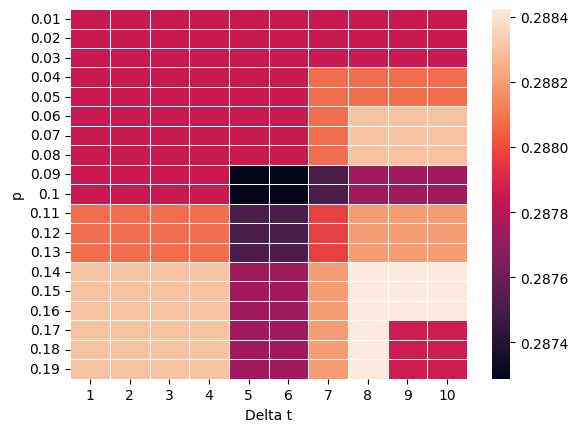

In [109]:
# check optimal value was reached
# risk events
ax = sns.heatmap(f1_matrix, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

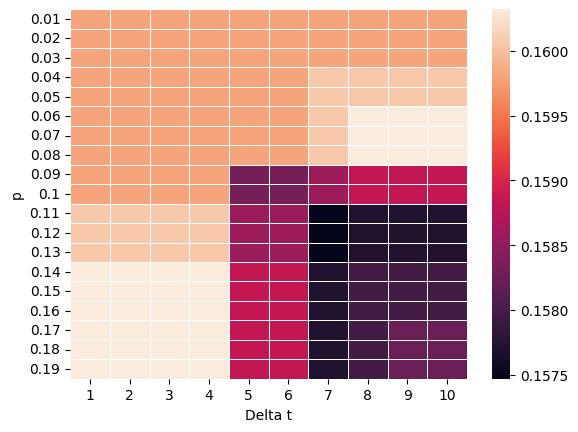

In [110]:
# check optimal value was reached
# risk behaviour window
ax1 = sns.heatmap(f1_matrix_window, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax1.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

##### Risk Event

In [111]:
# get best parameter and construct updated flags
# risk event
indices_event = np.where(f1_matrix == f1_matrix.max())
best_p_multi = np.round(p_list[indices_event[0][0]],2)
best_delta_t_multi = delta_t_list[indices_event[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_multi} or occur within less than {best_delta_t_multi} days.')

# train data
pred_flag_struct_mod_event = gen_full_flag_pruned(cut_flag_struct_event, true_id, df_train, trainMAE, true_time, best_p_multi, best_delta_t_multi)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_event, y_test = train_flag)

Prune FP if consecutive anomalies has difference less than 0.14 or occur within less than 8 days.

Confusion Matrix:
 [[71195   259]
 [ 1542   365]]

Recall (True Positive Rate): 0.1914
False Negative Rate: 0.8086
True Negative Rate: 0.9964
False Positive Rate: 0.0036
Precision: 0.5849
f1: 0.2884


{'FP': 259,
 'TN': 71195,
 'TP': 365,
 'FN': 1542,
 'Recall': 0.19140010487676978,
 'FNR': 0.8085998951232302,
 'TNR': 0.9963752903966188,
 'FPR': 0.0036247096033811964,
 'Precision': 0.5849358974358975,
 'f1': 0.2884235480047412}

In [112]:
# test data
pred_flag_struct_mod_test_event = gen_full_flag_pruned(cut_flag_struct_test_event, true_id_test, df_test, testMAE, true_time_test, best_p_multi, best_delta_t_multi)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_test_event, y_test = test_flag)


Confusion Matrix:
 [[30914   138]
 [  695   169]]

Recall (True Positive Rate): 0.1956
False Negative Rate: 0.8044
True Negative Rate: 0.9956
False Positive Rate: 0.0044
Precision: 0.5505
f1: 0.2886


{'FP': 138,
 'TN': 30914,
 'TP': 169,
 'FN': 695,
 'Recall': 0.19560185185185186,
 'FNR': 0.8043981481481481,
 'TNR': 0.9955558418137318,
 'FPR': 0.0044441581862681954,
 'Precision': 0.5504885993485342,
 'f1': 0.2886421861656704}

##### Risk Window

In [113]:
# get best parameter and construct updated flags
# risk event
indices_window = np.where(f1_matrix_window == f1_matrix_window.max())
best_p_multi_window = np.round(p_list[indices_window[0][0]],2)
best_delta_t_multi_window = delta_t_list[indices_window[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_uni} or occur within less than {best_delta_t_uni} days.')
# train data
pred_flag_struct_mod_window = gen_full_flag_pruned(cut_flag_struct_window, true_id, df_train, trainMAE, true_time, best_p_multi_window, best_delta_t_multi_window)
# evaluate performance
df_final['final_flag'] = pred_flag_struct_mod_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

Prune FP if consecutive anomalies has difference less than 0.01 or occur within less than 1 days.
precision: 0.16472545757071547 recall: 0.15615141955835962 f1: 0.1687170474516696


In [114]:
# test data
pred_flag_struct_mod_test_window = gen_full_flag_pruned(cut_flag_struct_test_window, true_id_test, df_test, testMAE, true_time_test, best_p_multi_window, best_delta_t_multi_window)
# evaluate performance
df_final_test['final_flag'] = pred_flag_struct_mod_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final_test,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.16326530612244897 recall: 0.17454545454545456 f1: 0.1687170474516696


#### Domain Knowledge: Weekend Effect

Significant decrease in FN (increase in TP) indicates that LSTM is able to learn about anomalies except those that are simply because they are transaction in the first weekend.

##### Risk Event

In [115]:
# training data
pred_flag_weekend_final = gen_flag_weekend_effect(pred_flag_struct_mod_event, df_train)
perf_nofit(y_pred = pred_flag_weekend_final, y_test = train_flag)


Confusion Matrix:
 [[71195   259]
 [  607  1300]]

Recall (True Positive Rate): 0.6817
False Negative Rate: 0.3183
True Negative Rate: 0.9964
False Positive Rate: 0.0036
Precision: 0.8339
f1: 0.7501


{'FP': 259,
 'TN': 71195,
 'TP': 1300,
 'FN': 607,
 'Recall': 0.6816990036706869,
 'FNR': 0.3183009963293131,
 'TNR': 0.9963752903966188,
 'FPR': 0.0036247096033811964,
 'Precision': 0.8338678640153945,
 'f1': 0.7501442585112521}

In [116]:
# test data
pred_flag_weekend_test_final = gen_flag_weekend_effect(pred_flag_struct_mod_test_event, df_test)
perf_nofit(y_pred = pred_flag_weekend_test_final, y_test = test_flag)


Confusion Matrix:
 [[30914   138]
 [  308   556]]

Recall (True Positive Rate): 0.6435
False Negative Rate: 0.3565
True Negative Rate: 0.9956
False Positive Rate: 0.0044
Precision: 0.8012
f1: 0.7137


{'FP': 138,
 'TN': 30914,
 'TP': 556,
 'FN': 308,
 'Recall': 0.6435185185185185,
 'FNR': 0.35648148148148145,
 'TNR': 0.9955558418137318,
 'FPR': 0.0044441581862681954,
 'Precision': 0.8011527377521613,
 'f1': 0.7137355584082156}

##### Risk Window

In [117]:
# train data
pred_flag_weekend_final_window = gen_flag_weekend_effect(pred_flag_struct_mod_window, df_train)
df_final['final_flag'] = pred_flag_weekend_final_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.11861074705111402 recall: 0.2854889589905363 f1: 0.1675925925925926


In [118]:
# Test Data
pred_flag_weekend_final_test_window = gen_flag_weekend_effect(pred_flag_struct_mod_test_window, df_test)
df_final_test['final_flag'] = pred_flag_weekend_final_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.1325478645066274 recall: 0.32727272727272727 f1: 0.18867924528301888


## LSTM Autoencoder (Univariate)

In [119]:
# set input matrix
# will always be dropped: id, deparment, time
ohe_col = X.columns[X.columns.str.startswith('department_')].to_list()
drop_col = ['minute_passed', 'unix', 'work_hour', 'weekend', 'time_diff'] + ohe_col
drop_col = ['minute_passed', 'unix'] + ohe_col
# drop_col = []+ohe_col
X_lstm = X.drop(drop_col, axis = 1)
X_lstm_test = X_test.drop(drop_col, axis = 1)
X_lstm

,individual_id,department,spend,time,work_hour,weekend,weekend_flag,time_diff
0,1,ops,-0.463358,2023-01-09 11:59:40.000,1.0,0.0,0.0,-0.677730
1,1,ops,-0.336158,2023-01-11 09:10:02.900,1.0,0.0,0.0,-0.062187
2,1,ops,-0.363763,2023-01-12 08:51:48.700,1.0,0.0,0.0,-0.354840
3,1,ops,-0.429799,2023-01-12 10:44:15.000,1.0,0.0,0.0,-0.652195
4,1,ops,-0.495834,2023-01-12 13:30:58.900,1.0,0.0,0.0,-0.639865
...,...,...,...,...,...,...,...,...
105272,2184,finance,-0.094749,2023-04-20 12:20:57.300,1.0,0.0,0.0,-0.358721
105273,2184,finance,0.518515,2023-04-21 10:12:27.800,1.0,0.0,0.0,-0.379879
105274,2184,finance,0.086037,2023-04-24 17:24:52.300,1.0,0.0,0.0,0.401570
105275,2185,investor_relations,0.271694,2023-02-08 12:50:15.000,1.0,0.0,0.0,-0.677730


In [120]:
# construct data
trainX, true_flag, true_dep, true_weekend_flag, true_id, true_time = gen_train_lstm(X_lstm, df, n_future = 1, n_past = 5, univariate = True, autoencoder = True)
testX, true_flag_test, true_dep_test, true_weekend_flag_test, true_id_test, true_time_test = gen_train_lstm(X_lstm_test, df, n_future = 1, n_past = 5, univariate = True, autoencoder = True)

trainX shape == (67318, 5, 1).
trainY shape == (0, 1).
true_flag shape == (72974,).
true_dep shape == (72974,).
true_weekend_flag shape == (72974,).
true_id shape == (67318,).
trainX shape == (29319, 5, 1).
trainY shape == (0, 1).
true_flag shape == (31775,).
true_dep shape == (31775,).
true_weekend_flag shape == (31775,).
true_id shape == (29319,).


In [121]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(2, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\Frans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 5)           │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 2)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 5, 2)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 5, 5)           │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1)           │             6 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410 (1.60 KB)

 Trainable params: 410 (1.60 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
tf.keras.utils.set_random_seed(1)
# to get predicitons from each epoch
predictions=prediction_for_each_epoch()

# fit the model
history = model.fit(trainX, trainX, epochs=5, batch_size=32, validation_split=0.1, verbose=1, callbacks=[predictions], shuffle=False)

Epoch 1/5
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.9925 - val_loss: 0.5364
Epoch 2/5
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6075 - val_loss: 0.5066
Epoch 3/5
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.5450 - val_loss: 0.5412
Epoch 4/5
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.5144 - val_loss: 0.7316
Epoch 5/5
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.4922 - val_loss: 0.7942


In [123]:
# make prediction
trainPredict_auto = model.predict(trainX)
testPredict_auto = model.predict(testX)

2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [124]:
trainMAE_auto = np.abs(trainPredict_auto - trainX)
testMAE_auto = np.abs(testPredict_auto - testX)

(array([8.4330e+03, 2.0322e+04, 1.8080e+03, 4.5800e+02, 2.6600e+02,
        2.7100e+02, 1.8000e+02, 2.8000e+01, 7.0000e+00, 2.0000e+00]),
 array([0.00784254, 0.54722139, 1.08660025, 1.6259791 , 2.16535795,
        2.7047368 , 3.24411565, 3.78349451, 4.32287336, 4.86225221,
        5.40163106]),
 <BarContainer object of 10 artists>)

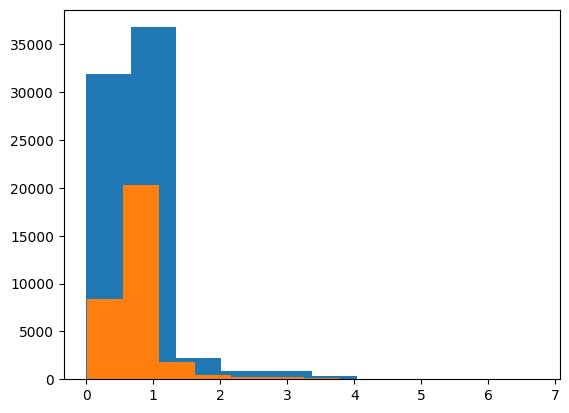

In [125]:
# calculate true MAE for all data points
trainMAE, true_x, id_auto = gen_final_pred(X = X_lstm, window_prediction=trainMAE_auto, true_id=true_id)
testMAE, true_x_test, id_auto_test = gen_final_pred(X = X_lstm_test, window_prediction=testMAE_auto, true_id=true_id_test)
plt.hist(trainMAE)
plt.hist(testMAE)

### Simple Threshold

In [126]:
# Grid search for best quantile

q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(q_list):
    # risk event
    pred_flag_simple = gen_simple_flag(trainMAE, id_auto, df_train, quantile = item)
    f1_event = perf_nofit(y_pred = pred_flag_simple, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_simple.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

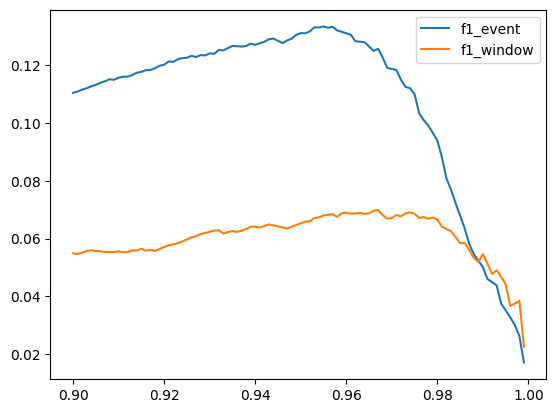

In [127]:
# check optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q1 = q_list[np.argmax(f1_list_event)]
best_q1_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [128]:
# train data
print(f'best_q is {best_q1}')
pred_flag_simple = gen_simple_flag(trainMAE, id_auto, df_train, quantile = best_q1)
perf_nofit(y_pred = pred_flag_simple, y_test = train_flag)

best_q is 0.9550000000000001

Confusion Matrix:
 [[68516  2938]
 [ 1561   346]]

Recall (True Positive Rate): 0.1814
False Negative Rate: 0.8186
True Negative Rate: 0.9589
False Positive Rate: 0.0411
Precision: 0.1054
f1: 0.1333


{'FP': 2938,
 'TN': 68516,
 'TP': 346,
 'FN': 1561,
 'Recall': 0.18143681174619822,
 'FNR': 0.8185631882538018,
 'TNR': 0.95888263778095,
 'FPR': 0.04111736221905002,
 'Precision': 0.10535931790499391,
 'f1': 0.13330764785205163}

In [129]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, id_auto_test, df_test, quantile = best_q1)
perf_nofit(y_pred = pred_flag_simple_test, y_test = test_flag)


Confusion Matrix:
 [[29791  1261]
 [  695   169]]

Recall (True Positive Rate): 0.1956
False Negative Rate: 0.8044
True Negative Rate: 0.9594
False Positive Rate: 0.0406
Precision: 0.1182
f1: 0.1473


{'FP': 1261,
 'TN': 29791,
 'TP': 169,
 'FN': 695,
 'Recall': 0.19560185185185186,
 'FNR': 0.8043981481481481,
 'TNR': 0.9593906994718536,
 'FPR': 0.04060930052814633,
 'Precision': 0.11818181818181818,
 'f1': 0.14734088927637318}

#### Risk Window

In [130]:
# train data
print(f'best_q for window is {best_q1_window}')
pred_flag_simple = gen_simple_flag(trainMAE, id_auto, df_train, quantile = best_q1_window)
df_final['final_flag'] = pred_flag_simple.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.967
precision: 0.04436860068259386 recall: 0.1640378548895899 f1: 0.06984553391537945


In [131]:
# Test data
pred_flag_simple_test = gen_simple_flag(testMAE, id_auto_test, df_test, quantile = best_q1_window)
df_final_test['final_flag'] = pred_flag_simple_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.0556640625 recall: 0.20727272727272728 f1: 0.08775981524249422


### Threshold by Department

In [132]:
# Grid search for best quantile
# Grid search for best quantile
q_list = np.array(range(900,1000))*0.001
f1_list_event = []
f1_list_window = []
for idx, item in enumerate(q_list):
    # risk event
    pred_flag_dep = gen_dep_flag(trainMAE, true_dep, id_auto, df_train, quantile = item)
    f1_event= perf_nofit(y_pred = pred_flag_dep, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    # risk window
    df_final['final_flag'] = pred_flag_dep.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

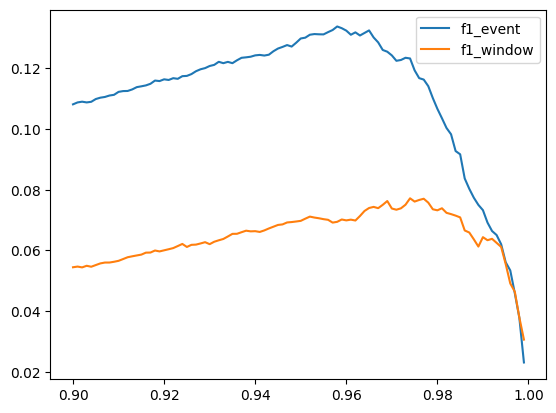

In [133]:
# check optimal value was reached
plt.plot(q_list, f1_list_event,  label="f1_event")
plt.plot(q_list, f1_list_window,  label="f1_window")
plt.legend()

best_q2 = q_list[np.argmax(f1_list_event)]
best_q2_window = q_list[np.argmax(f1_list_window)]

#### Risk Event

In [134]:
# train data
print(f'best_q for risk event is {best_q2}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, id_auto, df_train, quantile = best_q2)
perf_nofit(y_pred = pred_flag_dep, y_test = train_flag)

best_q for risk event is 0.9580000000000001

Confusion Matrix:
 [[68715  2739]
 [ 1574   333]]

Recall (True Positive Rate): 0.1746
False Negative Rate: 0.8254
True Negative Rate: 0.9617
False Positive Rate: 0.0383
Precision: 0.1084
f1: 0.1338


{'FP': 2739,
 'TN': 68715,
 'TP': 333,
 'FN': 1574,
 'Recall': 0.17461982170949134,
 'FNR': 0.8253801782905087,
 'TNR': 0.9616676463179108,
 'FPR': 0.038332353682089176,
 'Precision': 0.1083984375,
 'f1': 0.1337617995581442}

In [135]:
# test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, id_auto_test, df_test, quantile = best_q2)
perf_nofit(y_pred = pred_flag_dep_test, y_test = test_flag)


Confusion Matrix:
 [[29866  1186]
 [  705   159]]

Recall (True Positive Rate): 0.184
False Negative Rate: 0.816
True Negative Rate: 0.9618
False Positive Rate: 0.0382
Precision: 0.1182
f1: 0.144


{'FP': 1186,
 'TN': 29866,
 'TP': 159,
 'FN': 705,
 'Recall': 0.1840277777777778,
 'FNR': 0.8159722222222222,
 'TNR': 0.9618060028339559,
 'FPR': 0.038193997166044054,
 'Precision': 0.11821561338289963,
 'f1': 0.14395654142145767}

#### Risk Window

In [136]:
# train data
print(f'best_q for window is {best_q2_window}')
pred_flag_dep = gen_dep_flag(trainMAE, true_dep, id_auto, df_train, quantile = best_q2_window)
df_final['final_flag'] = pred_flag_dep.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best_q for window is 0.974
precision: 0.05177993527508091 recall: 0.15141955835962145 f1: 0.07717041800643086


In [137]:
# Test data
pred_flag_dep_test = gen_dep_flag(testMAE, true_dep_test, id_auto_test, df_test, quantile = best_q2_window)
df_final_test['final_flag'] = pred_flag_dep_test.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.06119951040391677 recall: 0.18181818181818182 f1: 0.09157509157509157


### Dynamic Threshold

In [138]:
# generate clean matrix of epoch predictions
predictions_epoch_train = pred_epoch_mat(X = X_lstm, predictions=predictions, true_id=true_id, training = True)
predictions_epoch_test = pred_epoch_mat(X = X_lstm_test, predictions=predictions, true_id=true_id_test, training = False)

In [139]:
# Grid search for best beta

beta_list = np.array(range(0, 10)) # ss encoder not censored
f1_list_event = []
f1_list_window = []

for idx, item in enumerate(beta_list):
    # risk event
    pred_flag_struct, cut_flag_struct = gen_struct_flag_auto(predictions_epoch_train, id_auto, df_train, true_x, beta=item)
    f1_event = perf_nofit(y_pred = pred_flag_struct, y_test = train_flag, print_=False)['f1']
    f1_list_event.append(f1_event)

    # risk window
    df_final['final_flag'] = pred_flag_struct.astype('bool')
    df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                        second_target_pred_col_name="final_flag")
    f1_list_window.append(f1_window)

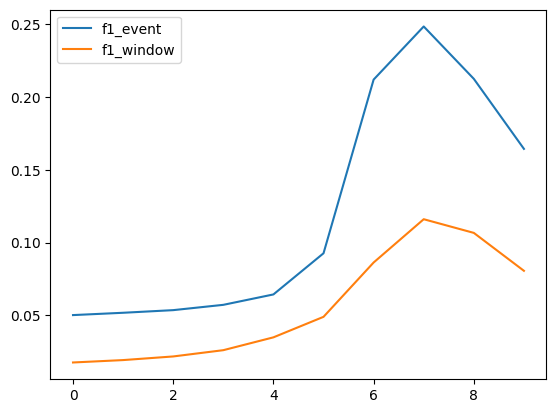

In [140]:
# check optimal value was reached
plt.plot(beta_list, f1_list_event,  label="f1_event")
plt.plot(beta_list, f1_list_window,  label="f1_window")
plt.legend()

best_beta_auto = beta_list[np.argmax(f1_list_event)]
best_beta_auto_window = beta_list[np.argmax(f1_list_window)]

#### Risk Event

In [141]:
# train data
print(f'best beta is {best_beta_auto}')
pred_flag_struct, cut_flag_struct_event = gen_struct_flag_auto(predictions_epoch_train, id_auto, df_train, true_x, beta=best_beta_auto)
perf_nofit(y_pred = pred_flag_struct, y_test = train_flag)

best beta is 7

Confusion Matrix:
 [[71233   221]
 [ 1605   302]]

Recall (True Positive Rate): 0.1584
False Negative Rate: 0.8416
True Negative Rate: 0.9969
False Positive Rate: 0.0031
Precision: 0.5774
f1: 0.2486


{'FP': 221,
 'TN': 71233,
 'TP': 302,
 'FN': 1605,
 'Recall': 0.15836392239119035,
 'FNR': 0.8416360776088097,
 'TNR': 0.9969071010720184,
 'FPR': 0.0030928989279816383,
 'Precision': 0.5774378585086042,
 'f1': 0.248559670781893}

In [142]:
# test data
pred_flag_struct_test, cut_flag_struct_test_event = gen_struct_flag_auto(predictions_epoch_test, id_auto_test, df_test, true_x_test, beta=best_beta_auto)
perf_nofit(y_pred = pred_flag_struct_test, y_test = test_flag)


Confusion Matrix:
 [[30968    84]
 [  738   126]]

Recall (True Positive Rate): 0.1458
False Negative Rate: 0.8542
True Negative Rate: 0.9973
False Positive Rate: 0.0027
Precision: 0.6
f1: 0.2346


{'FP': 84,
 'TN': 30968,
 'TP': 126,
 'FN': 738,
 'Recall': 0.14583333333333334,
 'FNR': 0.8541666666666666,
 'TNR': 0.9972948602344455,
 'FPR': 0.002705139765554554,
 'Precision': 0.6,
 'f1': 0.23463687150837992}

#### Risk Window

In [143]:
# train data
print(f'best beta for window is {best_beta_auto_window}')
pred_flag_struct_window, cut_flag_struct_window = gen_struct_flag_auto(predictions_epoch_train, id_auto, df_train, true_x, beta=best_beta_auto_window)
df_final['final_flag'] = pred_flag_struct_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

best beta for window is 7
precision: 0.12884615384615383 recall: 0.1056782334384858 f1: 0.11611785095320622


In [144]:
# Test data
pred_flag_struct_test_window, cut_flag_struct_test_window = gen_struct_flag_auto(predictions_epoch_test, id_auto_test, df_test, true_x_test, beta=best_beta_auto_window)
df_final_test['final_flag'] = pred_flag_struct_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.14761904761904762 recall: 0.11272727272727273 f1: 0.12783505154639177


## Post-processing

#### Pruning FP

In [145]:
# prune FP 
# structure threshold

# grid search to see best p and delta
p_list = np.arange(0.01, 0.2, 0.01)
delta_t_list = np.array(range(1,11)) # cooling period

f1_matrix = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t
f1_matrix_window = np.zeros((len(p_list), len(delta_t_list))) # p x delta_t

for i, p in enumerate(p_list):
    for j, delta_t in enumerate(delta_t_list):
        # risk event
        pred_flag_mod_event = gen_full_flag_pruned(cut_flag_struct_event, id_auto, df_train, trainMAE, true_time, p, delta_t)
        f1_event = perf_nofit(y_pred = pred_flag_mod_event, y_test = train_flag, print_=False)['f1']
        f1_matrix[i,j] = f1_event

        # risk window
        pred_flag_mod_window = gen_full_flag_pruned(cut_flag_struct_window, id_auto, df_train, trainMAE, true_time, p, delta_t)
        df_final['final_flag'] = pred_flag_mod_window.astype('bool')
        df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                      second_target_pred_col_name="final_flag")
        f1_matrix_window[i,j] = f1_window

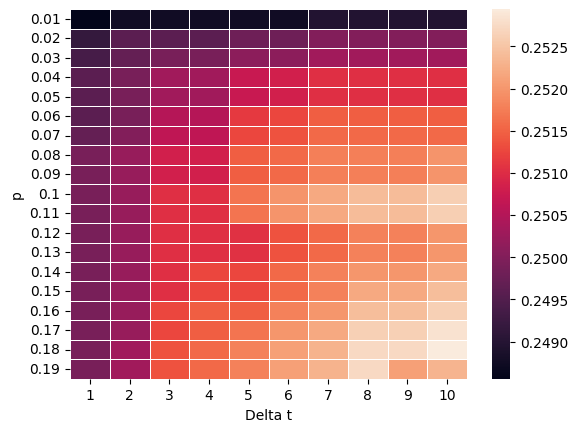

In [146]:
# check optimal value was reached
# risk events
ax = sns.heatmap(f1_matrix, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

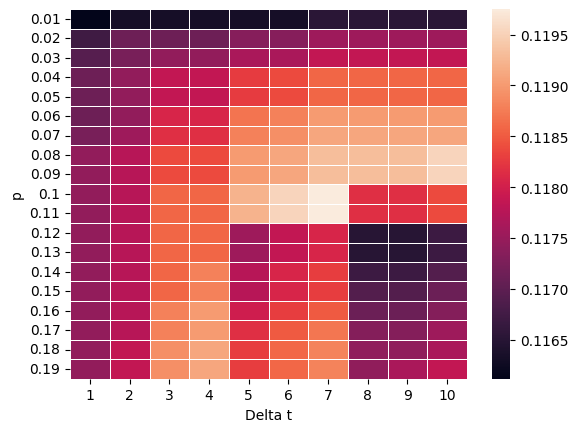

In [147]:
# check optimal value was reached
# risk behaviour window
ax_window = sns.heatmap(f1_matrix_window, linewidth=0.5, 
                 xticklabels=delta_t_list, 
                 yticklabels=np.round(p_list, 2))
ax_window.set(xlabel = 'Delta t', ylabel= 'p')
plt.show()

##### Risk Event

In [148]:
# get best parameter and construct updated flags
indices = np.where(f1_matrix == f1_matrix.max())
best_p_auto = np.round(p_list[indices[0][0]],2)
best_delta_t_auto = delta_t_list[indices[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_auto} or occur within less than {best_delta_t_auto} days.')

# train data
pred_flag_struct_mod_event = gen_full_flag_pruned(cut_flag_struct_event, id_auto, df_train, trainMAE, true_time, best_p_auto, best_delta_t_auto)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_event, y_test = train_flag)

Prune FP if consecutive anomalies has difference less than 0.18 or occur within less than 10 days.

Confusion Matrix:
 [[71282   172]
 [ 1606   301]]

Recall (True Positive Rate): 0.1578
False Negative Rate: 0.8422
True Negative Rate: 0.9976
False Positive Rate: 0.0024
Precision: 0.6364
f1: 0.2529


{'FP': 172,
 'TN': 71282,
 'TP': 301,
 'FN': 1606,
 'Recall': 0.1578395385422129,
 'FNR': 0.8421604614577871,
 'TNR': 0.9975928569429283,
 'FPR': 0.0024071430570716825,
 'Precision': 0.6363636363636364,
 'f1': 0.2529411764705882}

In [149]:
# test data
pred_flag_struct_mod_test_event = gen_full_flag_pruned(cut_flag_struct_test_event, id_auto_test, df_test, testMAE, true_time_test, best_p_auto, best_delta_t_auto)
# evaluate performance
perf_nofit(y_pred = pred_flag_struct_mod_test_event, y_test = test_flag)


Confusion Matrix:
 [[30979    73]
 [  739   125]]

Recall (True Positive Rate): 0.1447
False Negative Rate: 0.8553
True Negative Rate: 0.9976
False Positive Rate: 0.0024
Precision: 0.6313
f1: 0.2354


{'FP': 73,
 'TN': 30979,
 'TP': 125,
 'FN': 739,
 'Recall': 0.14467592592592593,
 'FNR': 0.8553240740740741,
 'TNR': 0.9976491047275537,
 'FPR': 0.002350895272446219,
 'Precision': 0.6313131313131313,
 'f1': 0.2354048964218456}

##### Risk Window

In [150]:
# get best parameter and construct updated flags
# risk event
indices_window = np.where(f1_matrix_window == f1_matrix_window.max())
best_p_uni_window = np.round(p_list[indices_window[0][0]],2)
best_delta_t_uni_window = delta_t_list[indices_window[1][0]]
print(f'Prune FP if consecutive anomalies has difference less than {best_p_uni} or occur within less than {best_delta_t_uni} days.')

# train data
pred_flag_struct_mod_window = gen_full_flag_pruned(cut_flag_struct_window, id_auto, df_train, trainMAE, true_time, best_p_uni_window, best_delta_t_uni_window)
# evaluate performance
df_final['final_flag'] = pred_flag_struct_mod_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

Prune FP if consecutive anomalies has difference less than 0.01 or occur within less than 1 days.
precision: 0.13814432989690723 recall: 0.1056782334384858 f1: 0.12783505154639177


In [151]:
# test data
pred_flag_struct_mod_test_window = gen_full_flag_pruned(cut_flag_struct_test_window, id_auto_test, df_test, testMAE, true_time_test, best_p_uni_window, best_delta_t_uni_window)
# evaluate performance
df_final_test['final_flag'] = pred_flag_struct_mod_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1_window = second_target_eval_func(df=df_final_test,
                                                                second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.15196078431372548 recall: 0.11272727272727273 f1: 0.12783505154639177


#### Domain Knowledge: Weekend Effect

Significant decrease in FN (increase in TP) indicates that LSTM is able to learn about anomalies except those that are simply because they are transaction in the first weekend.

##### Risk Event

In [152]:
# training data
pred_flag_weekend_final = gen_flag_weekend_effect(pred_flag_struct_mod_event, df_train)
perf_nofit(y_pred = pred_flag_weekend_final, y_test = train_flag)


Confusion Matrix:
 [[71282   172]
 [  668  1239]]

Recall (True Positive Rate): 0.6497
False Negative Rate: 0.3503
True Negative Rate: 0.9976
False Positive Rate: 0.0024
Precision: 0.8781
f1: 0.7468


{'FP': 172,
 'TN': 71282,
 'TP': 1239,
 'FN': 668,
 'Recall': 0.6497115888830624,
 'FNR': 0.3502884111169376,
 'TNR': 0.9975928569429283,
 'FPR': 0.0024071430570716825,
 'Precision': 0.8781006378454996,
 'f1': 0.7468354430379746}

In [153]:
# test data
pred_flag_weekend_test_final = gen_flag_weekend_effect(pred_flag_struct_mod_test_event, df_test)
perf_nofit(y_pred = pred_flag_weekend_test_final, y_test = test_flag)


Confusion Matrix:
 [[30979    73]
 [  349   515]]

Recall (True Positive Rate): 0.5961
False Negative Rate: 0.4039
True Negative Rate: 0.9976
False Positive Rate: 0.0024
Precision: 0.8759
f1: 0.7094


{'FP': 73,
 'TN': 30979,
 'TP': 515,
 'FN': 349,
 'Recall': 0.5960648148148148,
 'FNR': 0.4039351851851852,
 'TNR': 0.9976491047275537,
 'FPR': 0.002350895272446219,
 'Precision': 0.8758503401360545,
 'f1': 0.709366391184573}

##### Risk Window

In [154]:
# train data
pred_flag_weekend_final_window = gen_flag_weekend_effect(pred_flag_struct_mod_window, df_train)
df_final['final_flag'] = pred_flag_weekend_final_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.11056338028169015 recall: 0.2476340694006309 f1: 0.1528724440116845


In [155]:
# Test Data
pred_flag_weekend_final_test_window = gen_flag_weekend_effect(pred_flag_struct_mod_test_window, df_test)
df_final_test['final_flag'] = pred_flag_weekend_final_test_window.astype('bool')
df_with_pred_evaluations, precision, recall, f1 = second_target_eval_func(df=df_final_test,
                                                                    second_target_pred_col_name="final_flag")
print("precision:", precision, "recall:", recall, "f1:", f1)

precision: 0.12794612794612795 recall: 0.27636363636363637 f1: 0.17491369390103567


In [156]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf Lloyds_Banking_Group_Notebook.ipynb

[NbConvertApp] Converting notebook Lloyds_Banking_Group_Notebook.ipynb to pdf
[NbConvertApp] Support files will be in Lloyds_Banking_Group_Notebook_files\
[NbConvertApp] Making directory .\Lloyds_Banking_Group_Notebook_files
[NbConvertApp] Writing 393088 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | x failed: xelatex notebook.tex -quiet
b"This is XeTeX, Version 3.141592653-2.6-0.999995 (TeX Live 2023) (preloaded format=xelatex)\r\n restricted \\write18 enabled.\r\nentering extended mode\r\n(./notebook.tex\r\nLaTeX2e <2023-06-01> patch level 1\r\nL3 programming layer <2023-08-29>\r\n(c:/Users/Frans/AppData/Roaming/TinyTeX/texmf-dist/tex/latex/base/article.cls\r\nDocument Class: article 2023/05/17 v1.4n Standard LaTeX document class\r\n(c:/Users/Frans/AppData/Roaming/TinyTeX/texmf-dist/tex/latex/base/size11.clo))\r\n\r\n! LaTeX Error: File `tcolorbox.sty' not found.\r\n\r\nType X t

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>